# Notebook to generate the plots for the paper

### Getting the data

If you do not already have the data to run this this notebook, you need to
download it from here.



### Standards modules

In [1]:
%reload_ext autoreload
%autoreload 2

In [ ]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import scipy
from scipy import signal
import pathlib
import itertools
import glob
import json
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

### Custom Modules

In [ ]:
sys.path.append("../scripts")

import classification_algorithms as ca
import reduced_models as rm
import task_analysis as ta

import misc
import gmac

In [83]:
# Define the font family and size
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams['font.weight'] = 'light'  # Use 'light' font weight
plt.rcParams.update({"text.usetex": True, "font.family": "Helvetica"})


## Define notebook level constants

In [8]:
# Sampling rate for the data is 50ms
dT = 0.02
Fs = int(1 / dT)

In [9]:
# Generate all possible combinations of parameters.
def generate_param_combinations_am(param_ranges: dict) -> dict:
    """
    Generate all possible combinations of parameters.
    """
    for _fc in param_ranges["fc"]:
        for _nc in param_ranges["nc"]:
            for _nam in param_ranges["nam"]:
                yield {
                    "fc": _fc,
                    "nc": int(_nc),
                    "nam": int(_nam)
                }

## Read the Controls and Patients Data

In [10]:
# Read healthy and control data
left, right = misc.read_data(subject_type='control')
aff, unaff = misc.read_data(subject_type='patient')

# Assign segments for each subject
left = pd.concat([misc.assign_segments(left[left.subject == subj], dur_th=1, dT=dT)
                  for subj in left.subject.unique()], axis=0)
right = pd.concat([misc.assign_segments(right[right.subject == subj], dur_th=1, dT=dT)
                   for subj in right.subject.unique()])
aff = pd.concat([misc.assign_segments(aff[aff.subject == subj], dur_th=1, dT=dT)
                 for subj in aff.subject.unique()])
unaff = pd.concat([misc.assign_segments(unaff[unaff.subject == subj], dur_th=1, dT=dT)
                   for subj in unaff.subject.unique()])

# All limbs data ddf
datadf = {
    "left": left,
    "right": right,
    "aff": aff,
    "unaff": unaff
}

## Read the Pitch and Accl. Mag. Estimation files

In [11]:
basedir = "../data/output-r1-full-new"

# Read gmac parameters.
with open(pathlib.Path(basedir, "gmac", "gmac_params.json"), "r") as f:
    gmac_param_ranges = json.load(f)

In [12]:
# Read pitch, gm, and gmac performance file
gmac_perf = pd.read_csv(pathlib.Path(basedir, "gmac", "perf_gmac.csv"))

## Read Subash et 2022 results file

In [13]:
# Read data from Tanya's paper
tempdf = pd.read_csv("../data/subash22data.csv")
del tempdf["Unnamed: 0"]

# Organize data into dictionary
limbsdef = {
    "left": "left",
    "right": "right",
    "aff": "affected",
    "unaff": "unaffected"
}
subash22df = {
    lk: tempdf[tempdf.hand == lv].reset_index(drop=True)
    for lk, lv in limbsdef.items()
}

In [14]:
# Limbs
limbs = ["left", "right", "aff", "unaff"]
subash_perf_gmac = {
    "youden": [],
    "sensitivity": [],
    "specificity": [],
}

model = "GMAC"
for i, limb in enumerate(limbs):
    _inx = (subash22df[limb].method == model)
    subash_perf_gmac["youden"].append(subash22df[limb][_inx]["youden"].values)
    subash_perf_gmac["sensitivity"].append(subash22df[limb][_inx]["sensitivity"].values)
    subash_perf_gmac["specificity"].append(subash22df[limb][_inx]["specificity"].values)

# RF Intersubject
subash_perf_rfinter = {
    "youden": [],
    "sensitivity": [],
    "specificity": [],
}

model = "RF inter"
for i, limb in enumerate(limbs):
    _inx = (subash22df[limb].method == model)
    subash_perf_rfinter["youden"].append(subash22df[limb][_inx]["youden"].values)
    subash_perf_rfinter["sensitivity"].append(subash22df[limb][_inx]["sensitivity"].values)
    subash_perf_rfinter["specificity"].append(subash22df[limb][_inx]["specificity"].values)

# RF Intrasubject
subash_perf_rfintra = {
    "youden": [],
    "sensitivity": [],
    "specificity": [],
}

model = "RF intra"
for i, limb in enumerate(limbs):
    _inx = (subash22df[limb].method == model)
    subash_perf_rfintra["youden"].append(subash22df[limb][_inx]["youden"].values)
    subash_perf_rfintra["sensitivity"].append(subash22df[limb][_inx]["sensitivity"].values)
    subash_perf_rfintra["specificity"].append(subash22df[limb][_inx]["specificity"].values)

# RF Intrasubject mean
subash_perf_rfintra_mean = {
    "youden": [],
    "sensitivity": [],
    "specificity": [],
}

model = "RF intra"
for i, limb in enumerate(limbs):
    _inx = (subash22df[limb].method == model)
    subash_perf_rfintra_mean["youden"].append(subash22df[limb][_inx].groupby("subject")["youden"].mean().values)
    subash_perf_rfintra_mean["sensitivity"].append(subash22df[limb][_inx].groupby("subject")["youden"].mean().values)
    subash_perf_rfintra_mean["specificity"].append(subash22df[limb][_inx].groupby("subject")["youden"].mean().values)

## GMAC Performance: Inter-Subject without validation

In [15]:
# Number of all possible combinations
Ncombs = len(list(misc.generate_param_combinations_gmac(gmac_param_ranges)))

# All parameter combinations.
param_combs_enum = list(misc.generate_param_combinations_gmac_wenum(gmac_param_ranges))

In [16]:
# Generate data for heatmap
# Get performance for the different parameters combinations.
_keys = ["np", "fc", "nc", "nam", "p_th", "p_th_band", "am_th", "am_th_band"]
lens = [len(gmac_param_ranges[_k]) for _k in _keys]
perf = np.zeros(lens)
med = np.zeros(lens)
iqr = np.zeros(lens)
limbs = ["left", "right", "aff", "unaff"]
for i, pcvalenum in enumerate(param_combs_enum):
    _ix, _pcval = pcvalenum
    # Go through all limbs
    _vals = []
    # for l, _lmb in enumerate(limbs):
    _inx = ((gmac_perf.np == _pcval["np"]) &
            (gmac_perf.fc == _pcval["fc"]) &
            (gmac_perf.nc == _pcval["nc"]) &
            (gmac_perf.nam == _pcval["nam"]) &
            (gmac_perf.am_th == _pcval["am_th"]) &
            (gmac_perf.am_th_band == _pcval["am_th_band"]) &
            (gmac_perf.p_th == _pcval["p_th"]) &
            (gmac_perf.p_th_band == _pcval["p_th_band"]))
    _vals.append(gmac_perf.loc[_inx, "youden"].values)
    _ixstr = [f"{k}: {v:2d}" for k, v in _ix.items()]
    sys.stdout.write(f"\r{i:5d} {', '.join(_ixstr)}")
    sys.stdout.flush()
    # Compute the cost.
    _vals = np.hstack(_vals)
    # Computer performance
    _perfs = [np.percentile(_vals, q) for q in [25, 50, 75]]
    _i = tuple(_ix[_k] for _k in _keys)
    perf[_i] = _perfs[1] * (1 - (_perfs[2] - _perfs[0]))
    med[_i] = _perfs[1]
    iqr[_i] = _perfs[2] - _perfs[0]

# Save the perf data as a numpy file
np.save(pathlib.Path(basedir, "all_perf.npy"), perf)

10259 np:  2, fc:  1, nc:  1, nam:  2, p_th: 18, p_th_band:  4, am_th:  2, am_th_band:  0

In [17]:
print(perf.shape)
print(med.shape)

(3, 2, 2, 3, 19, 5, 3, 1)
(3, 2, 2, 3, 19, 5, 3, 1)


In [18]:
# Maximum performance
# ["np", "fc", "nc", "nam", "p_th", "p_th_band", "am_th", "am_th_band"]
_perf = perf[:, :, :, :, :, :, :, :]
maxperf = np.max(_perf)
maxinx = np.where(_perf == maxperf)
bestarg = [
    gmac_param_ranges["np"][maxinx[0][0]],
    gmac_param_ranges["fc"][maxinx[1][0]],
    gmac_param_ranges["nc"][maxinx[2][0]],
    gmac_param_ranges["nam"][maxinx[3][0]],
    gmac_param_ranges["p_th"][:][maxinx[4][0]],
    gmac_param_ranges["p_th_band"][maxinx[5][0]],
    gmac_param_ranges["am_th"][maxinx[6][0]],
    gmac_param_ranges["am_th_band"][maxinx[7][0]]
]
bestarg

[50, 0.01, 2, 50, 10, 40, 0.1, 0]

In [80]:
# How different is the maximum?
_perf = perf[:, :, :, :, :, :, :, :]
# Maximum performance
maxperf = np.max(_perf)
minperf = np.min(_perf)
_inx = (100 * (_perf - minperf) / (maxperf - minperf)) > 95
perfinx = np.where(_inx)
topperf = _perf[perfinx]
topperfparam = np.array([
    [
        gmac_param_ranges["np"][perfinx[0][i]],
        gmac_param_ranges["fc"][perfinx[1][i]],
        gmac_param_ranges["nc"][perfinx[2][i]],
        gmac_param_ranges["nam"][perfinx[3][i]],
        gmac_param_ranges["p_th"][:][perfinx[4][i]],
        gmac_param_ranges["p_th_band"][perfinx[5][i]],
        gmac_param_ranges["am_th"][perfinx[6][i]],
        gmac_param_ranges["am_th_band"][perfinx[7][i]],
        topperf[i]
    ]
    for i in range(len(perfinx[0]))
])
# Sort by performance
_inxpersort = np.argsort(topperf)[::-1]
topperfparam = topperfparam[_inxpersort, :]
perfinxsort = np.array(perfinx).T[_inxpersort, :]
np.set_printoptions(precision=4, suppress=True)
print(topperfparam)

[[50.      0.01    2.     50.     10.     40.      0.1     0.      0.4091]
 [50.      0.01    2.     25.     10.     40.      0.1     0.      0.4087]
 [25.      0.01    2.     50.     20.     60.      0.1     0.      0.4056]
 [50.      0.1     2.     25.     10.     40.      0.1     0.      0.402 ]
 [25.      0.01    2.     25.     20.     60.      0.1     0.      0.4015]
 [50.      0.01    2.      1.     10.     40.      0.1     0.      0.3998]
 [50.      0.1     2.     50.     10.     40.      0.1     0.      0.3979]
 [25.      0.01    1.     25.     20.     60.      0.1     0.      0.397 ]
 [25.      0.01    1.     50.     20.     60.      0.1     0.      0.3955]
 [50.      0.01    1.     25.     10.     40.      0.1     0.      0.3954]
 [50.      0.01    1.     50.     10.     40.      0.1     0.      0.3933]
 [25.      0.01    2.      1.     20.     60.      0.1     0.      0.3911]
 [50.      0.1     1.      1.     10.     40.      0.1     0.      0.3911]
 [50.      0.01    2.    

In [20]:
maxperf, minperf

(0.409127608200469, 0.0)

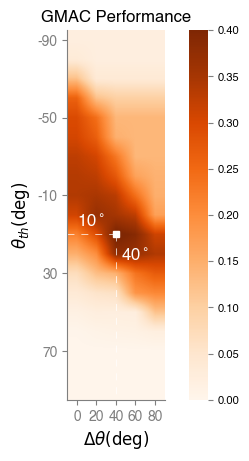

In [21]:
fig = plt.figure()
maxinx = perfinxsort[0]

ax = fig.add_subplot(1, 1, 1)
# Create the heatmap using imshow
_hm = ax.imshow(_perf[perfinxsort[0, 0],
                      perfinxsort[0, 1],
                      perfinxsort[0, 2],
                      perfinxsort[0, 3],
                      :, :,
                      perfinxsort[0, 6],
                      perfinxsort[0, 7]], cmap='Oranges', interpolation='bilinear',
                vmin=0, vmax=0.4)

ax.set_ylabel(r'$\theta_{th} (\deg)$', fontsize=12)
ax.set_yticks(np.arange(len(gmac_param_ranges["p_th"])),
              labels=gmac_param_ranges["p_th"],
              color="tab:gray")
ax.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=5))
ax.spines["left"].set_visible(True)
ax.spines["left"].set_color("tab:gray")
ax.yaxis.set_tick_params(color='tab:grey')
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_color("tab:gray")

# Set x ticks
ax.set_xticks(np.arange(len(gmac_param_ranges["p_th_band"])),
                labels=gmac_param_ranges["p_th_band"],
                color="tab:gray")

# Add labels to the axes
ax.set_xlabel(r'$\Delta\theta (\deg)$', fontsize=12)
ax.xaxis.set_tick_params(color='tab:grey')

# # Plot the max. point.
ax.plot(maxinx[5], maxinx[4], 's', color='white', markersize=5)
ax.plot([maxinx[5], maxinx[5]],
        [maxinx[4], len(gmac_param_ranges["p_th"]) - 0.5], lw=0.5,
        linestyle='dashed', dashes=(10, 10),
        color='white')
ax.plot([-0.5, maxinx[5]],
        [maxinx[4], maxinx[4]], lw=0.5,
        linestyle='dashed', dashes=(10, 10),
        color='white')
# Show the max. argument
ax.text(maxinx[5] - 1.25, maxinx[4] - 0.25,
        (f"{bestarg[4]:0.0f}" + r"$^\circ$"),
        color='white', ha='center', va='bottom',
        fontsize=12)
ax.text(maxinx[5] + 1, maxinx[4] + 1.5,
        (f"{bestarg[5]:0.0f}" + r"$^\circ$"),
        color='white', ha='center', va='bottom',
        fontsize=12)

# Color map
_cbar = plt.colorbar(_hm)
# Modify colorbar settings
_cbar.ax.tick_params(labelsize=8)  # Set tick label font size
_cbar.set_alpha(0.7)  # Set colorbar opacity (alpha value)
_cbar.outline.set_linewidth(0.)  # Set the colorbar outline thickness
_cbar.ax.yaxis.set_tick_params(color='tab:gray')

ax.set_title("GMAC Performance")

plt.subplots_adjust(wspace=-0.2)

# Save plot
fig.savefig(pathlib.Path(basedir, "gmac_perf_hm.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(basedir, "gmac_perf_hm.svg"), bbox_inches="tight")

## Extra plots

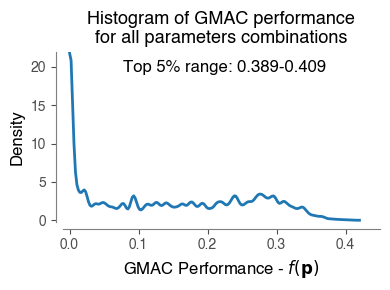

In [79]:
# All possible Younden index, Sensitivity, and Specificity
fig = plt.figure(figsize=(4, 3))

# Histrogram of all Younden indices
ax = fig.add_subplot(111)
sns.kdeplot(data=perf.flatten(), bw_adjust=0.2, clip=[0, 1], lw=2, ax=ax)
ax.set_xlim(-0.01, 0.45)
ax.set_ylim(-0.2, 22)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.set_ylabel("Density", fontsize=12)
ax.set_xlabel(r"GMAC Performance - $f\left(\mathbf{p}\right)$", fontsize=12)
ax.set_title("Histogram of GMAC performance\nfor all parameters combinations", fontsize=13)

# Display the range details of the performance measure.
ax.text(0.225, 20,
        "\n".join((f"Top 5% range: {topperfparam[-1, -1]:0.3f}-{topperfparam[0, -1]:0.3f}",)),
        color='black', ha='center', va='center', fontsize=12)

plt.tight_layout()

# Save plot
fig.savefig(pathlib.Path(basedir, "all_gmacperf_hist.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(basedir, "all_gmacperf_hist.svg"), bbox_inches="tight")

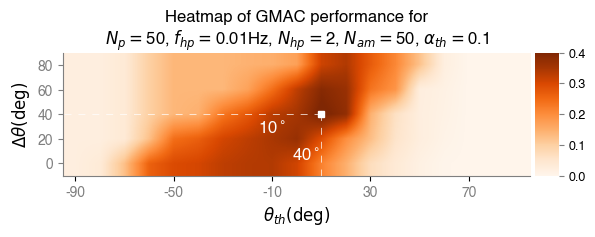

In [32]:
maxinx = perfinxsort[0]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# Create the heatmap using imshow
_hm = ax.imshow(_perf[perfinxsort[0, 0],
                      perfinxsort[0, 1],
                      perfinxsort[0, 2],
                      perfinxsort[0, 3],
                      :, ::-1,
                      perfinxsort[0, 6],
                      perfinxsort[0, 7]].T, cmap='Oranges', interpolation='bilinear',
                vmin=0, vmax=0.4)

ax.set_xlabel(r'$\theta_{th} (\deg)$', fontsize=12)
ax.set_xticks(np.arange(len(gmac_param_ranges["p_th"])),
              labels=gmac_param_ranges["p_th"],
              color="tab:gray")
ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=5))
ax.spines["left"].set_visible(True)
ax.spines["left"].set_color("tab:gray")
ax.yaxis.set_tick_params(color='tab:grey')
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_color("tab:gray")

# Set y ticks
ax.set_yticks(np.arange(len(gmac_param_ranges["p_th_band"])),
              labels=gmac_param_ranges["p_th_band"][::-1],
              color="tab:gray")

# Add labels to the axes
ax.set_ylabel(r'$\Delta\theta (\deg)$', fontsize=12)
ax.yaxis.set_tick_params(color='tab:grey')

# Plot the max. point.
ax.plot(maxinx[4], maxinx[5], 's', color='white', markersize=5)
ax.plot([maxinx[4], -0.5],
        [maxinx[5], maxinx[5]], lw=0.5,
        linestyle='dashed', dashes=(10, 10),
        color='white')
ax.plot([maxinx[4], maxinx[4]],
        [len(gmac_param_ranges["p_th_band"]) - 0.5, maxinx[5]],
        lw=0.5,
        linestyle='dashed', dashes=(10, 10),
        color='white')
# Show the max. argument
ax.text(maxinx[4] - 2.0, maxinx[5] + 0.9,
        (f"{bestarg[4]:0.0f}" + r"$^\circ$"),
        color='white', ha='center', va='bottom',
        fontsize=12)
ax.text(maxinx[4] - 0.6, maxinx[5] + 2.0,
        (f"{bestarg[5]:0.0f}" + r"$^\circ$"),
        color='white', ha='center', va='bottom',
        fontsize=12)

# Color map
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
_cbar = plt.colorbar(_hm, cax=cax)
# Modify colorbar settings
_cbar.ax.tick_params(labelsize=9)  # Set tick label font size
_cbar.set_alpha(0.7)  # Set colorbar opacity (alpha value)
_cbar.outline.set_linewidth(0.)  # Set the colorbar outline thickness
_cbar.ax.yaxis.set_tick_params(color='tab:gray')
_str = ("Heatmap of GMAC performance for\n" + 
        ", ".join((r"$N_p=$" + f"{int(topperfparam[0, 0])}",
                   r"$f_{hp}=$" + f"{topperfparam[0, 1]}Hz",
                   r"$N_{hp}= $" + f"{int(topperfparam[0, 2])}",
                   r"$N_{am}= $" + f"{int(topperfparam[0, 3])}",
                   r"$\alpha_{th}=$" + f"{topperfparam[0, 6]:}")))
ax.set_title(_str, fontsize=12)

# Save plot
fig.savefig(pathlib.Path(basedir, "gmac_perf_hm.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(basedir, "gmac_perf_hm.svg"), bbox_inches="tight")


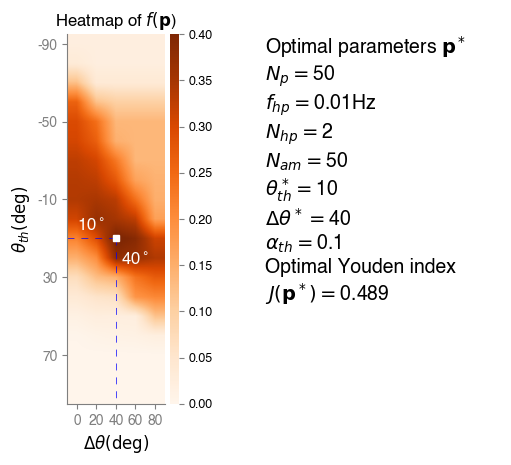

In [34]:
fig = plt.figure()
maxinx = perfinxsort[0]

ax = fig.add_subplot(1, 2, 1)
# Create the heatmap using imshow
_hm = ax.imshow(_perf[perfinxsort[0, 0],
                      perfinxsort[0, 1],
                      perfinxsort[0, 2],
                      perfinxsort[0, 3],
                      :, :,
                      perfinxsort[0, 6],
                      perfinxsort[0, 7]], cmap='Oranges', interpolation='bilinear',
                vmin=0, vmax=0.4)

ax.set_ylabel(r'$\theta_{th} (\deg)$', fontsize=12)
ax.set_yticks(np.arange(len(gmac_param_ranges["p_th"])),
              labels=gmac_param_ranges["p_th"],
              color="tab:gray")
ax.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=5))
ax.spines["left"].set_visible(True)
ax.spines["left"].set_color("tab:gray")
ax.yaxis.set_tick_params(color='tab:grey')
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_color("tab:gray")

# Set x ticks
ax.set_xticks(np.arange(len(gmac_param_ranges["p_th_band"])),
                labels=gmac_param_ranges["p_th_band"],
                color="tab:gray")

# Add labels to the axes
ax.set_xlabel(r'$\Delta\theta (\deg)$', fontsize=12)
ax.xaxis.set_tick_params(color='tab:grey')

# # Plot the max. point.
ax.plot([maxinx[5], maxinx[5]],
        [maxinx[4], len(gmac_param_ranges["p_th"]) - 0.5], lw=0.5,
        linestyle='dashed', dashes=(10, 10),
        color='blue')
ax.plot([-0.5, maxinx[5]],
        [maxinx[4], maxinx[4]], lw=0.5,
        linestyle='dashed', dashes=(10, 10),
        color='blue')
ax.plot(maxinx[5], maxinx[4], 's', color='white', markersize=5)
# Show the max. argument
ax.text(maxinx[5] - 1.25, maxinx[4] - 0.25,
        (f"{bestarg[4]:0.0f}" + r"$^\circ$"),
        color='white', ha='center', va='bottom',
        fontsize=12)
ax.text(maxinx[5] + 1, maxinx[4] + 1.5,
        (f"{bestarg[5]:0.0f}" + r"$^\circ$"),
        color='white', ha='center', va='bottom',
        fontsize=12)

# Color map
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.05)
_cbar = plt.colorbar(_hm, cax=cax)
# Modify colorbar settings
_cbar.ax.tick_params(labelsize=9)  # Set tick label font size
_cbar.set_alpha(0.7)  # Set colorbar opacity (alpha value)
_cbar.outline.set_linewidth(0.)  # Set the colorbar outline thickness
_cbar.ax.yaxis.set_tick_params(color='tab:gray')

_str = r"Heatmap of $f(\mathbf{p}$)"
                #   r"$N_p=f_s$, $f_{hp}=0.01Hz$, $N_{hp}=4$, $N_{am}=f_s/2$, $\alpha_{th}=0.1$"))
ax.set_title(_str, fontsize=12)

ax = fig.add_subplot(1, 2, 2)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
# Remove frame
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
# Remove x and y ticks
ax.set_xticks([])
ax.set_yticks([])
_jmax = med[perfinxsort[0, 0],
            perfinxsort[0, 1],
            perfinxsort[0, 2],
            perfinxsort[0, 3],
            perfinxsort[0, 4],
            perfinxsort[0, 5],
            perfinxsort[0, 6],
            perfinxsort[0, 7]]
ax.text(0.0, 1.0, 
        "\n".join((r"Optimal parameters $\mathbf{p}^*$",
                   r"$N_p=$" + f"{int(topperfparam[0, 0])}",
                   r"$f_{hp}=$" + f"{topperfparam[0, 1]}Hz",
                   r"$N_{hp}= $" + f"{int(topperfparam[0, 2])}",
                   r"$N_{am}= $" + f"{int(topperfparam[0, 3])}",
                   r"$\theta_{th}^*=$" + f"{int(topperfparam[0, 4])}",
                   r"$\Delta\theta^*=$" + f"{int(topperfparam[0, 5])}",
                   r"$\alpha_{th}=$" + f"{topperfparam[0, 6]:}"
                   "",
                   r"Optimal Youden index",
                   r"$J(\mathbf{p}^*) = $" + f"{_jmax:0.3f}")),
        fontsize=14, ha='left', va='top')

plt.subplots_adjust(wspace=0.1)

# Save plot
fig.savefig(pathlib.Path(basedir, "gmac_perf_hm_vert.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(basedir, "gmac_perf_hm_vert.svg"), bbox_inches="tight")

# Inter-subject GMAC Model with validation (Leave-One-Subject-One-Limb-Out)

In [37]:
# Leave-one-out validation
limbsubj = list(set(zip(gmac_perf.limb, gmac_perf.subject)))

# Get performance for the different parameters combinations.
# Get performance for the different parameters combinations.
_keys = ["np", "fc", "nc", "nam", "p_th", "p_th_band", "am_th", "am_th_band"]
lens = [len(limbsubj)] + [len(gmac_param_ranges[_k]) for _k in _keys]
perf_loslo = np.zeros(lens)
med = np.zeros(lens)
iqr = np.zeros(lens)

# All parameter combinations.
param_combs_enum = list(misc.generate_param_combinations_gmac_wenum(gmac_param_ranges))
for l, (_lmb, _subj) in enumerate(limbsubj):
    # Index to leave out.
    _looinx = ~((gmac_perf.limb == _lmb) &
                (gmac_perf.subject == _subj))
    # Generate data for heatmap
    for i, pcvalenum in enumerate(param_combs_enum):
        _ix, _pcval = pcvalenum
        # Go through all limbs
        _vals = []
        _inx = ((gmac_perf.np == _pcval["np"]) &
                (gmac_perf.fc == _pcval["fc"]) &
                (gmac_perf.nc == _pcval["nc"]) &
                (gmac_perf.nam == _pcval["nam"]) &
                (gmac_perf.am_th == _pcval["am_th"]) &
                (gmac_perf.am_th_band == _pcval["am_th_band"]) &
                (gmac_perf.p_th == _pcval["p_th"]) &
                (gmac_perf.p_th_band == _pcval["p_th_band"]))
        _vals.append(gmac_perf.loc[_looinx & _inx, "youden"].values)
        _ixstr = [f"{k}: {v:2d}" for k, v in _ix.items()]
        sys.stdout.write(f"\r{l:2d} {i:5d} {', '.join(_ixstr)}")
        sys.stdout.flush()
        
        # Compute the cost.
        _vals = np.hstack(_vals)
        # Computer performance
        _perfs = [np.percentile(_vals, q) for q in [25, 50, 75]]
        _i = tuple([l]) + tuple(_ix[_k] for _k in _keys)
        perf_loslo[_i] = _perfs[1] * (1 - (_perfs[2] - _perfs[0]))
        med[_i] = _perfs[1]
        iqr[_i] = _perfs[2] - _perfs[0]

# Save the perf data as a numpy file
np.save(pathlib.Path(basedir, "all_perf_loslo.npy"), perf_loslo)

29 10259 np:  2, fc:  1, nc:  1, nam:  2, p_th: 18, p_th_band:  4, am_th:  2, am_th_band:  0

In [38]:
maxinx = np.array([np.where(_perf == np.max(_perf)) for _perf in perf_loslo]).T[0].T
bestarg = [
    [
        gmac_param_ranges["np"][_mx[0]],
        gmac_param_ranges["fc"][_mx[1]],
        gmac_param_ranges["nc"][_mx[2]],
        gmac_param_ranges["nam"][_mx[3]],
        gmac_param_ranges["p_th"][_mx[4]],
        gmac_param_ranges["p_th_band"][_mx[5]],
        gmac_param_ranges["am_th"][_mx[6]],
        gmac_param_ranges["am_th_band"][_mx[7]]
    ] for _mx in maxinx
]
bestarg

[[50, 0.01, 2, 50, 10, 40, 0.1, 0],
 [50, 0.01, 2, 25, 10, 40, 0.1, 0],
 [25, 0.01, 2, 50, 20, 60, 0.1, 0],
 [25, 0.01, 1, 25, 20, 60, 0.1, 0],
 [50, 0.01, 2, 50, 10, 40, 0.1, 0],
 [25, 0.1, 1, 50, 10, 40, 0.1, 0],
 [50, 0.01, 2, 50, 10, 40, 0.1, 0],
 [25, 0.1, 1, 50, 10, 40, 0.1, 0],
 [50, 0.01, 2, 25, 10, 40, 0.1, 0],
 [50, 0.01, 2, 50, 10, 40, 0.1, 0],
 [25, 0.01, 1, 25, 20, 60, 0.1, 0],
 [50, 0.01, 2, 50, 10, 40, 0.1, 0],
 [50, 0.01, 2, 50, 10, 40, 0.1, 0],
 [50, 0.01, 2, 50, 10, 40, 0.1, 0],
 [50, 0.01, 2, 25, 10, 40, 0.1, 0],
 [50, 0.01, 2, 25, 10, 40, 0.1, 0],
 [50, 0.01, 2, 50, 10, 40, 0.1, 0],
 [50, 0.01, 2, 25, 10, 40, 0.1, 0],
 [50, 0.01, 2, 50, 10, 40, 0.1, 0],
 [25, 0.01, 2, 50, 20, 60, 0.1, 0],
 [50, 0.01, 2, 25, 10, 40, 0.1, 0],
 [50, 0.01, 2, 50, 10, 40, 0.1, 0],
 [50, 0.01, 2, 25, 10, 40, 0.1, 0],
 [50, 0.01, 2, 50, 10, 40, 0.1, 0],
 [25, 0.01, 2, 50, 20, 60, 0.1, 0],
 [25, 0.01, 2, 50, 20, 60, 0.1, 0],
 [50, 0.01, 2, 50, 10, 40, 0.1, 0],
 [50, 0.1, 2, 25, 10, 40, 0.1,

In [39]:
# Get the performance of the left out subject for the best parameters.
losloperf = {
    "youden": np.zeros(len(limbsubj)),
    "sensitivity": np.zeros(len(limbsubj)),
    "specificity": np.zeros(len(limbsubj)),
}
for i, (_lmb, _subj) in enumerate(limbsubj):
    # Index to leave out.
    _looinx = ((gmac_perf.limb == _lmb) &
               (gmac_perf.subject == _subj))
    _inx = ((gmac_perf.np == bestarg[i][0]) &
            (gmac_perf.fc == bestarg[i][1]) &
            (gmac_perf.nc == bestarg[i][2]) &
            (gmac_perf.nam == bestarg[i][3]) &
            (gmac_perf.p_th == bestarg[i][4]) &
            (gmac_perf.p_th_band == bestarg[i][5]) &
            (gmac_perf.am_th == bestarg[i][6]) &
            (gmac_perf.am_th_band == bestarg[i][7]))
    # Computer performance
    losloperf["youden"][i] = gmac_perf.loc[_looinx & _inx, "youden"].values[0]
    losloperf["sensitivity"][i] = gmac_perf.loc[_looinx & _inx, "sensitivity"].values[0]
    losloperf["specificity"][i] = gmac_perf.loc[_looinx & _inx, "specificity"].values[0]

#### Comparing performance with Subash et al. 2022

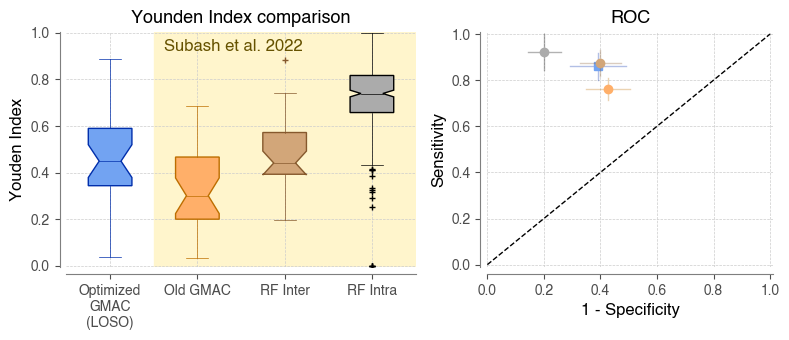

In [40]:
# Combine data from all limbs
lightc = ["#f08181", "#72a3f2", "#ffaf69", "#d2a679", "#ababab", "#b2b266", "#b2b266"]
darkc = ["#a80a0a", "#002eab", "#bd6e00", "#86592d", "black", "#55552b", "#55552b"]
fig = plt.figure(figsize=(8, 3.5))
gs = gridspec.GridSpec(1, 2, height_ratios=[1], width_ratios=[4.4, 3.6])
ax = plt.subplot(gs[0, 0])

# Current performance
j = 1
ax.boxplot(x=losloperf["youden"], positions=[j],
        widths=0.5, notch=True, patch_artist=True,
        boxprops=dict(facecolor=lightc[j], color=darkc[j], alpha=1.0),
        capprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
        whiskerprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
        flierprops=dict(color=darkc[j], markeredgecolor=darkc[j],
                        markerfacecolor=darkc[j], marker='+', markersize=4),
        medianprops=dict(color=darkc[j], alpha=1.0, lw=0.5))

# Previous performance
# GMAC
j = 2
_vals = np.hstack([subash_perf_gmac["youden"][i] for i in range(4)])
ax.boxplot(x=_vals, positions=[j],
           widths=0.5, notch=True, patch_artist=True,
           boxprops=dict(facecolor=lightc[j], color=darkc[j], alpha=1.0),
           capprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           whiskerprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           flierprops=dict(color=darkc[j], markeredgecolor=darkc[j],
                           markerfacecolor=darkc[j], marker='+', markersize=4),
           medianprops=dict(color=darkc[j], alpha=1.0, lw=0.5))
# RF INTER
j = 3
_vals = np.hstack([subash_perf_rfinter["youden"][i] for i in range(4)])
ax.boxplot(x=_vals, positions=[j],
           widths=0.5, notch=True, patch_artist=True,
           boxprops=dict(facecolor=lightc[j], color=darkc[j], alpha=1.0),
           capprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           whiskerprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           flierprops=dict(color=darkc[j], markeredgecolor=darkc[j],
                           markerfacecolor=darkc[j], marker='+', markersize=4),
           medianprops=dict(color=darkc[j], alpha=1.0, lw=0.5))
# RF INTRA
j = 4
_vals = np.hstack([subash_perf_rfintra["youden"][i] for i in range(4)])
_vals = _vals[~np.isnan(_vals)]
ax.boxplot(x=_vals, positions=[j],
           widths=0.5, notch=True, patch_artist=True,
           boxprops=dict(facecolor=lightc[j], color=darkc[j], alpha=1.0),
           capprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           whiskerprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           flierprops=dict(color=darkc[j], markeredgecolor=darkc[j],
                           markerfacecolor=darkc[j], marker='+', markersize=4),
           medianprops=dict(color=darkc[j], alpha=1.0, lw=0.5))
# Backgrounds
background = plt.Rectangle((0.25, 0), 1, 1,
                           transform=ax.transAxes,
                           color='#fff5cc', zorder=-1)
ax.add_patch(background)
ax.text(0.28, 0.97, "Subash et al. 2022", ha="left", va="top", fontsize=12,
        color="#665200", transform=ax.transAxes,)

ax.set_ylim(-0.005, 1.005)
ax.set_xlim(0.5, 4.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.8', linestyle='--', linewidth=0.5);
ax.set_xticklabels(
    ["Optimized\nGMAC\n(LOSO)",] +
    ["Old GMAC", "RF Inter", "RF Intra"],
)
ax.set_ylabel("Youden Index", fontsize=12)
ax.set_title("Younden Index comparison", fontsize=13)

# ROC plot
ax = plt.subplot(gs[0, 1])
ax.plot([0, 1], [0, 1], lw=1, color="black", ls="--")
# LOO Optimized GMAC
_valsens = losloperf["sensitivity"]
_valspec = losloperf["specificity"]
_xmean, _ymean = np.mean(_valspec), np.mean(_valsens)
_xstd, _ystd = np.std(_valspec), np.std(_valsens)
ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
        [_ymean, _ymean], color=darkc[1], alpha=0.3, lw=1)
ax.plot([1 - _xmean, 1 - _xmean],
        [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[1], alpha=0.3, lw=1)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=6, color=lightc[1], alpha=1)

# Old GMAC
_valsens = np.hstack([subash_perf_gmac["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([subash_perf_gmac["specificity"][i] for i in range(4)])
_xmean, _ymean = np.mean(_valspec), np.mean(_valsens)
_xstd, _ystd = np.std(_valspec), np.std(_valsens)
ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
        [_ymean, _ymean], color=darkc[2], alpha=0.3, lw=1)
ax.plot([1 - _xmean, 1 - _xmean],
        [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[2], alpha=0.3, lw=1)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=6, color=lightc[2], alpha=1)
# RF Inter
_valsens = np.hstack([subash_perf_rfinter["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([subash_perf_rfinter["specificity"][i] for i in range(4)])
_xmean, _ymean = np.mean(_valspec), np.mean(_valsens)
_xstd, _ystd = np.std(_valspec), np.std(_valsens)
ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
        [_ymean, _ymean], color=darkc[3], alpha=0.3, lw=1)
ax.plot([1 - _xmean, 1 - _xmean],
        [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[3], alpha=0.3, lw=1)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=6, color=lightc[3], alpha=1)
# RF Intra
_valsens = np.hstack([subash_perf_rfintra["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([subash_perf_rfintra["specificity"][i] for i in range(4)])
_xmean, _ymean = np.nanmean(_valspec), np.nanmean(_valsens)
_xstd, _ystd = np.nanstd(_valspec), np.nanstd(_valsens)
ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
        [_ymean, _ymean], color=darkc[4], alpha=0.3, lw=1)
ax.plot([1 - _xmean, 1 - _xmean],
        [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[4], alpha=0.3, lw=1)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=6, color=lightc[4], alpha=1)
ax.set_ylim(-0.01, 1.01)
ax.set_xlim(0.0, 1.01)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.8', linestyle='--', linewidth=0.5);
ax.set_ylabel("Sensitivity", fontsize=12)
ax.set_xlabel("1 - Specificity", fontsize=12)
ax.set_title("ROC", fontsize=13)

plt.tight_layout()

fig.savefig(pathlib.Path(basedir, "gmac_summary_all_med.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(basedir, "gmac_summary_all_med.svg"), bbox_inches="tight")

#### Comparing performance with Subash et al. 2022 (means, CIs)

In [41]:
def compute_bootstrap_mean_ci(rawdata, n_bootstrap_samples=1000):
    # Find the bootstrap means and CIs.
    bootstrap_means = np.zeros(n_bootstrap_samples)
    for i in range(n_bootstrap_samples):
        bootstrap_sample = np.random.choice(rawdata, size=len(rawdata), replace=True)
        bootstrap_means[i] = np.mean(bootstrap_sample)
    return (np.nanmean(bootstrap_means),
            np.nanpercentile(bootstrap_means, [2.5, 97.5]))

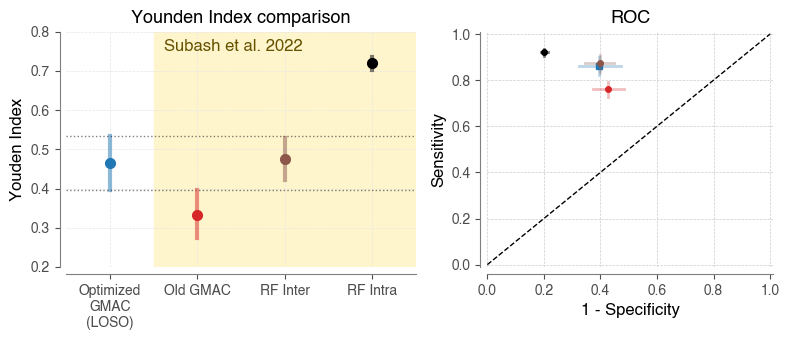

In [42]:
# Combine data from all limbs
lightc = ["#f08181", "#72a3f2", "#ffaf69", "#d2a679", "#ababab", "#b2b266", "#b2b266"]
# darkc = ["#a80a0a", "#002eab", "#bd6e00", "#86592d", "black", "#55552b", "#55552b"]
darkc = ["#a80a0a", "tab:blue", "tab:red", "tab:brown", "black", "#55552b", "#55552b"]
darkc_dict = {f"{i}": c for i, c in enumerate(darkc)}
fig = plt.figure(figsize=(8, 3.5))
gs = gridspec.GridSpec(1, 2, height_ratios=[1], width_ratios=[4.4, 3.6])

# Number of bootstrap samples
means = {}
ci95 = {}
# Find the bootstrap means and CIs.
means["newgmac"], ci95["newgmac"] = compute_bootstrap_mean_ci(losloperf["youden"])
means["oldgmac"], ci95["oldgmac"] = compute_bootstrap_mean_ci(np.hstack([subash_perf_gmac["youden"][i] for i in range(4)]))
means["rfinter"], ci95["rfinter"] = compute_bootstrap_mean_ci(np.hstack([subash_perf_rfinter["youden"][i] for i in range(4)]))
means["rfintra"], ci95["rfintra"] = compute_bootstrap_mean_ci(np.hstack([subash_perf_rfintra["youden"][i] for i in range(4)]))

ax = plt.subplot(gs[0, 0])
# Current performance
j = 1
ax.plot([j-0.], [means["newgmac"]], color=darkc[j], marker="o", markersize=7)
ax.plot([j, j], ci95["newgmac"], color=darkc[j], lw=3, alpha=0.5)
ax.axhline(ci95["newgmac"][0], color="black", alpha=0.5, lw=1, ls="dotted")
ax.axhline(ci95["newgmac"][1], color="black", alpha=0.5, lw=1, ls="dotted")
j = 2
ax.plot([j-0.], [means["oldgmac"]], color=darkc[j], marker="o", markersize=7)
ax.plot([j, j], ci95["oldgmac"], color=darkc[j], lw=3, alpha=0.5)
j = 3
ax.plot([j-0.], [means["rfinter"]], color=darkc[j], marker="o", markersize=7)
ax.plot([j, j], ci95["rfinter"], color=darkc[j], lw=3, alpha=0.5)
j = 4
ax.plot([j-0.], [means["rfintra"]], color=darkc[j], marker="o", markersize=7)
ax.plot([j, j], ci95["rfintra"], color=darkc[j], lw=3, alpha=0.5)

# Backgrounds
background = plt.Rectangle((0.25, 0), 1, 1,
                           transform=ax.transAxes,
                           color='#fff5cc', zorder=-1)
ax.add_patch(background)
ax.text(0.28, 0.97, "Subash et al. 2022", ha="left", va="top", fontsize=12,
        color="#665200", transform=ax.transAxes,)

ax.set_ylim(0.2, 0.8)
ax.set_xlim(0.5, 4.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.9', linestyle='--', linewidth=0.5);
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(
    ["Optimized\nGMAC\n(LOSO)",] +
    ["Old GMAC", "RF Inter", "RF Intra"],
)
ax.set_ylabel("Youden Index", fontsize=12)
ax.set_title("Younden Index comparison", fontsize=13)

# ROC plot
ax = plt.subplot(gs[0, 1])
ax.plot([0, 1], [0, 1], lw=1, color="black", ls="--")
# LOO Optimized GMAC
_valsens = losloperf["sensitivity"]
_valspec = losloperf["specificity"]
_xmean, _xci = compute_bootstrap_mean_ci(losloperf["specificity"])
_ymean, _yci = compute_bootstrap_mean_ci(losloperf["sensitivity"])
ax.plot(1 - _xci, [_ymean, _ymean], color=darkc[1], alpha=0.3, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color=darkc[1], alpha=0.3, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=4, color=darkc[1], alpha=1)

# Old GMAC
_valsens = np.hstack([subash_perf_gmac["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([subash_perf_gmac["specificity"][i] for i in range(4)])
_xmean, _xci = compute_bootstrap_mean_ci(_valspec)
_ymean, _yci = compute_bootstrap_mean_ci(_valsens)
ax.plot(1 - _xci, [_ymean, _ymean], color=darkc[2], alpha=0.3, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color=darkc[2], alpha=0.3, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=4, color=darkc[2], alpha=1)

# RF Inter
_valsens = np.hstack([subash_perf_rfinter["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([subash_perf_rfinter["specificity"][i] for i in range(4)])
_xmean, _xci = compute_bootstrap_mean_ci(_valspec)
_ymean, _yci = compute_bootstrap_mean_ci(_valsens)
ax.plot(1 - _xci, [_ymean, _ymean], color=darkc[3], alpha=0.3, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color=darkc[3], alpha=0.3, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=4, color=darkc[3], alpha=1)

# RF Intra
_valsens = np.hstack([subash_perf_rfintra["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([subash_perf_rfintra["specificity"][i] for i in range(4)])
_xmean, _xci = compute_bootstrap_mean_ci(_valspec)
_ymean, _yci = compute_bootstrap_mean_ci(_valsens)
ax.plot(1 - _xci, [_ymean, _ymean], color=darkc[4], alpha=0.5, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color=darkc[4], alpha=0.5, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=4, color=darkc[4], alpha=1)

ax.set_ylim(-0.01, 1.01)
ax.set_xlim(0.0, 1.01)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.8', linestyle='--', linewidth=0.5);
ax.set_ylabel("Sensitivity", fontsize=12)
ax.set_xlabel("1 - Specificity", fontsize=12)
ax.set_title("ROC", fontsize=13)

plt.tight_layout()

fig.savefig(pathlib.Path(basedir, "gmac_summary_all.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(basedir, "gmac_summary_all.svg"), bbox_inches="tight")

# All Subject Inter-subject GMAC Model with validation (Leave-One-Subject)

In [43]:
# Add a healthy / stroke subject column
_subjtype = [
    f"H{_row[1]['subject']}" if _row[1]["limb"] in ["left", "right"]
    else f"S{_row[1]['subject']}"
    for i, _row in enumerate(gmac_perf[["subject", "limb"]].iterrows())
]
gmac_perf["subjtype"] = _subjtype
gmac_perf

,subject,np,fc,nc,nam,p_th,p_th_band,am_th,am_th_band,limb,...,FN,TP,TNr,FPr,FNr,TPr,sensitivity,specificity,youden,subjtype
0,2,1,0.01,1,1,-90,0,0.00,0,left,...,0,17133,0.000082,0.293752,0.000000,0.706166,1.000000,0.000281,0.000281,H2
1,2,1,0.01,1,1,-90,0,0.10,0,left,...,2291,14842,0.025142,0.268692,0.094427,0.611739,0.866281,0.085566,-0.048153,H2
2,2,1,0.01,1,1,-90,0,0.25,0,left,...,6797,10336,0.130904,0.162930,0.280150,0.426016,0.603280,0.445504,0.048784,H2
3,2,1,0.01,1,1,-90,20,0.00,0,left,...,0,17133,0.000082,0.293752,0.000000,0.706166,1.000000,0.000281,0.000281,H2
4,2,1,0.01,1,1,-90,20,0.10,0,left,...,2291,14842,0.025142,0.268692,0.094427,0.611739,0.866281,0.085566,-0.048153,H2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307795,5,50,0.10,2,50,90,60,0.10,0,unaff,...,15134,0,0.381301,0.000000,0.618699,0.000000,0.000000,1.000000,0.000000,S5
307796,5,50,0.10,2,50,90,60,0.25,0,unaff,...,15134,0,0.381301,0.000000,0.618699,0.000000,0.000000,1.000000,0.000000,S5
307797,5,50,0.10,2,50,90,80,0.00,0,unaff,...,15134,0,0.381301,0.000000,0.618699,0.000000,0.000000,1.000000,0.000000,S5
307798,5,50,0.10,2,50,90,80,0.10,0,unaff,...,15134,0,0.381301,0.000000,0.618699,0.000000,0.000000,1.000000,0.000000,S5


In [44]:
# Leave-one-out validation
subjs = list(set(gmac_perf.subjtype))

# Get performance for the different parameters combinations.
_keys = ["np", "fc", "nc", "nam", "p_th", "p_th_band", "am_th", "am_th_band"]
lens = [len(subjs)] + [len(gmac_param_ranges[_k]) for _k in _keys]
perf_loso = np.zeros(lens)
med = np.zeros(lens)
iqr = np.zeros(lens)

# All parameter combinations.
param_combs_enum = list(misc.generate_param_combinations_gmac_wenum(gmac_param_ranges))
for l, _subj in enumerate(subjs):
    # Index to leave out.
    _losoinx = ~(gmac_perf.subjtype == _subj)
    # Generate data for heatmap
    for i, pcvalenum in enumerate(param_combs_enum):
        _ix, _pcval = pcvalenum
        # Go through all limbs
        _inx = ((gmac_perf.np == _pcval["np"]) &
                (gmac_perf.fc == _pcval["fc"]) &
                (gmac_perf.nc == _pcval["nc"]) &
                (gmac_perf.nam == _pcval["nam"]) &
                (gmac_perf.am_th == _pcval["am_th"]) &
                (gmac_perf.am_th_band == _pcval["am_th_band"]) &
                (gmac_perf.p_th == _pcval["p_th"]) &
                (gmac_perf.p_th_band == _pcval["p_th_band"]))
        _vals = gmac_perf.loc[_losoinx & _inx, "youden"].values
        _ixstr = [f"{k}: {v:2d}" for k, v in _ix.items()]
        sys.stdout.write(f"\r{l:2d} {i:5d} {', '.join(_ixstr)}")
        sys.stdout.flush()
        # Compute the cost.
        # Compute performance.
        _perfs = [np.percentile(_vals, q) for q in [25, 50, 75]]
        _i = tuple([l]) + tuple(_ix[_k] for _k in _keys)
        perf_loso[_i] = _perfs[1] * (1 - (_perfs[2] - _perfs[0]))
        med[_i] = _perfs[1]
        iqr[_i] = _perfs[2] - _perfs[0]

# Save the perf data as a numpy file
np.save(pathlib.Path(basedir, f"all_perf_loso.npy"), perf_loso)

14 10259 np:  2, fc:  1, nc:  1, nam:  2, p_th: 18, p_th_band:  4, am_th:  2, am_th_band:  0

In [45]:
perf_loso = np.load(pathlib.Path(basedir, f"all_perf_loso.npy"))
maxinx = np.array([np.where(_perf == np.max(_perf)) for _perf in perf_loso]).T[0].T
bestargs = [
    [
        gmac_param_ranges["np"][_mx[0]],
        gmac_param_ranges["fc"][_mx[1]],
        gmac_param_ranges["nc"][_mx[2]],
        gmac_param_ranges["nam"][_mx[3]],
        gmac_param_ranges["p_th"][_mx[4]],
        gmac_param_ranges["p_th_band"][_mx[5]],
        gmac_param_ranges["am_th"][_mx[6]],
        gmac_param_ranges["am_th_band"][_mx[7]]
    ] for _mx in maxinx
]
bestargs

[[50, 0.01, 2, 25, 10, 40, 0.1, 0],
 [50, 0.1, 2, 25, 10, 40, 0.1, 0],
 [50, 0.01, 2, 50, 10, 40, 0.1, 0],
 [50, 0.01, 2, 25, 10, 40, 0.1, 0],
 [50, 0.01, 2, 25, 10, 40, 0.1, 0],
 [50, 0.01, 2, 50, 10, 40, 0.1, 0],
 [25, 0.01, 1, 25, 20, 60, 0.1, 0],
 [50, 0.01, 2, 50, 10, 40, 0.1, 0],
 [50, 0.01, 2, 25, 10, 40, 0.1, 0],
 [25, 0.1, 2, 25, 20, 60, 0.1, 0],
 [50, 0.01, 2, 50, 10, 40, 0.1, 0],
 [25, 0.1, 2, 25, 10, 40, 0.1, 0],
 [50, 0.1, 2, 25, 10, 40, 0.1, 0],
 [50, 0.01, 2, 25, 10, 40, 0.1, 0],
 [50, 0.01, 2, 25, 10, 40, 0.1, 0]]

In [46]:
subjs = list(set(gmac_perf.subjtype))

# Get the performance of the left out subject for the best parameters.
losoperf = {
    "youden": np.zeros(2 * len(subjs)),
    "sensitivity": np.zeros(2 * len(subjs)),
    "specificity": np.zeros(2 * len(subjs)),
}
# for i, (_lmb, _subj) in enumerate(subjs):
for i, _subj in enumerate(subjs):
    # Index to leave out.
    _looinx = (gmac_perf.subjtype == _subj)
    _inx = ((gmac_perf.np == bestargs[i][0]) &
            (gmac_perf.fc == bestargs[i][1]) &
            (gmac_perf.nc == bestargs[i][2]) &
            (gmac_perf.nam == bestargs[i][3]) &
            (gmac_perf.p_th == bestargs[i][4]) &
            (gmac_perf.p_th_band == bestargs[i][5]) &
            (gmac_perf.am_th == bestargs[i][6]) &
            (gmac_perf.am_th_band == bestargs[i][7]))
    # Computer performance
    losoperf["youden"][2 * i] = gmac_perf.loc[_looinx & _inx, "youden"].values[0]
    losoperf["youden"][2 * i + 1] = gmac_perf.loc[_looinx & _inx, "youden"].values[1]
    losoperf["sensitivity"][2 * i] = gmac_perf.loc[_looinx & _inx, "sensitivity"].values[0]
    losoperf["sensitivity"][2 * i + 1] = gmac_perf.loc[_looinx & _inx, "sensitivity"].values[1]
    losoperf["specificity"][2 * i] = gmac_perf.loc[_looinx & _inx, "specificity"].values[0]
    losoperf["specificity"][2 * i + 1] = gmac_perf.loc[_looinx & _inx, "specificity"].values[1]

#### Comparing performance with Subash et al. 2022

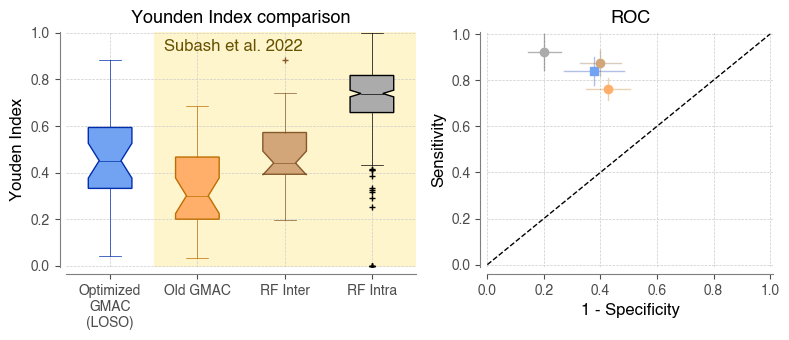

In [47]:
# Combine data from all limbs
lightc = ["#f08181", "#72a3f2", "#ffaf69", "#d2a679", "#ababab", "#b2b266", "#b2b266"]
darkc = ["#a80a0a", "#002eab", "#bd6e00", "#86592d", "black", "#55552b", "#55552b"]
fig = plt.figure(figsize=(8, 3.5))
gs = gridspec.GridSpec(1, 2, height_ratios=[1], width_ratios=[4.4, 3.6])
ax = plt.subplot(gs[0, 0])

# Current performance
j = 1
ax.boxplot(x=losoperf["youden"], positions=[j],
           widths=0.5, notch=True, patch_artist=True,
           boxprops=dict(facecolor=lightc[j], color=darkc[j], alpha=1.0),
           capprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           whiskerprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           flierprops=dict(color=darkc[j], markeredgecolor=darkc[j],
                           markerfacecolor=darkc[j], marker='+', markersize=4),
           medianprops=dict(color=darkc[j], alpha=1.0, lw=0.5))

# Previous performance
# GMAC
j = 2
_vals = np.hstack([subash_perf_gmac["youden"][i] for i in range(4)])
ax.boxplot(x=_vals, positions=[j],
           widths=0.5, notch=True, patch_artist=True,
           boxprops=dict(facecolor=lightc[j], color=darkc[j], alpha=1.0),
           capprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           whiskerprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           flierprops=dict(color=darkc[j], markeredgecolor=darkc[j],
                           markerfacecolor=darkc[j], marker='+', markersize=4),
           medianprops=dict(color=darkc[j], alpha=1.0, lw=0.5))
# RF INTER
j = 3
_vals = np.hstack([subash_perf_rfinter["youden"][i] for i in range(4)])
ax.boxplot(x=_vals, positions=[j],
           widths=0.5, notch=True, patch_artist=True,
           boxprops=dict(facecolor=lightc[j], color=darkc[j], alpha=1.0),
           capprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           whiskerprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           flierprops=dict(color=darkc[j], markeredgecolor=darkc[j],
                           markerfacecolor=darkc[j], marker='+', markersize=4),
           medianprops=dict(color=darkc[j], alpha=1.0, lw=0.5))
# RF INTRA
j = 4
_vals = np.hstack([subash_perf_rfintra["youden"][i] for i in range(4)])
_vals = _vals[~np.isnan(_vals)]
ax.boxplot(x=_vals, positions=[j],
           widths=0.5, notch=True, patch_artist=True,
           boxprops=dict(facecolor=lightc[j], color=darkc[j], alpha=1.0),
           capprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           whiskerprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           flierprops=dict(color=darkc[j], markeredgecolor=darkc[j],
                           markerfacecolor=darkc[j], marker='+', markersize=4),
           medianprops=dict(color=darkc[j], alpha=1.0, lw=0.5))
# Backgrounds
background = plt.Rectangle((0.25, 0), 1, 1,
                           transform=ax.transAxes,
                           color='#fff5cc', zorder=-1)
ax.add_patch(background)
ax.text(0.28, 0.97, "Subash et al. 2022", ha="left", va="top", fontsize=12,
        color="#665200", transform=ax.transAxes,)

ax.set_ylim(-0.005, 1.005)
ax.set_xlim(0.5, 4.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.8', linestyle='--', linewidth=0.5);
ax.set_xticklabels(
    ["Optimized\nGMAC\n(LOSO)",] +
    ["Old GMAC", "RF Inter", "RF Intra"],
)
ax.set_ylabel("Youden Index", fontsize=12)
ax.set_title("Younden Index comparison", fontsize=13)

# ROC plot
ax = plt.subplot(gs[0, 1])
ax.plot([0, 1], [0, 1], lw=1, color="black", ls="--")
# LOO Optimized GMAC
_valsens = losoperf["sensitivity"]
_valspec = losoperf["specificity"]
_xmean, _ymean = np.mean(_valspec), np.mean(_valsens)
_xstd, _ystd = np.std(_valspec), np.std(_valsens)
ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
        [_ymean, _ymean], color=darkc[1], alpha=0.3, lw=1)
ax.plot([1 - _xmean, 1 - _xmean],
        [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[1], alpha=0.3, lw=1)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=6, color=lightc[1], alpha=1)

# Old GMAC
_valsens = np.hstack([subash_perf_gmac["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([subash_perf_gmac["specificity"][i] for i in range(4)])
_xmean, _ymean = np.mean(_valspec), np.mean(_valsens)
_xstd, _ystd = np.std(_valspec), np.std(_valsens)
ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
        [_ymean, _ymean], color=darkc[2], alpha=0.3, lw=1)
ax.plot([1 - _xmean, 1 - _xmean],
        [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[2], alpha=0.3, lw=1)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=6, color=lightc[2], alpha=1)
# RF Inter
_valsens = np.hstack([subash_perf_rfinter["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([subash_perf_rfinter["specificity"][i] for i in range(4)])
_xmean, _ymean = np.mean(_valspec), np.mean(_valsens)
_xstd, _ystd = np.std(_valspec), np.std(_valsens)
ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
        [_ymean, _ymean], color=darkc[3], alpha=0.3, lw=1)
ax.plot([1 - _xmean, 1 - _xmean],
        [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[3], alpha=0.3, lw=1)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=6, color=lightc[3], alpha=1)
# RF Intra
_valsens = np.hstack([subash_perf_rfintra["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([subash_perf_rfintra["specificity"][i] for i in range(4)])
_xmean, _ymean = np.nanmean(_valspec), np.nanmean(_valsens)
_xstd, _ystd = np.nanstd(_valspec), np.nanstd(_valsens)
ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
        [_ymean, _ymean], color=darkc[4], alpha=0.3, lw=1)
ax.plot([1 - _xmean, 1 - _xmean],
        [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[4], alpha=0.3, lw=1)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=6, color=lightc[4], alpha=1)
ax.set_ylim(-0.01, 1.01)
ax.set_xlim(0.0, 1.01)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.8', linestyle='--', linewidth=0.5);
ax.set_ylabel("Sensitivity", fontsize=12)
ax.set_xlabel("1 - Specificity", fontsize=12)
ax.set_title("ROC", fontsize=13)

plt.tight_layout()

fig.savefig(pathlib.Path(basedir, f"gmac_summary_all_med_loso.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(basedir, f"gmac_summary_all_med_loso.svg"), bbox_inches="tight")

#### Comparing performance with Subash et al. 2022 (means, CIs)

In [48]:
def compute_bootstrap_mean_ci(rawdata, n_bootstrap_samples=1000):
    # Find the bootstrap means and CIs.
    bootstrap_means = np.zeros(n_bootstrap_samples)
    for i in range(n_bootstrap_samples):
        bootstrap_sample = np.random.choice(rawdata, size=len(rawdata), replace=True)
        bootstrap_means[i] = np.mean(bootstrap_sample)
    return (np.nanmean(bootstrap_means),
            np.nanpercentile(bootstrap_means, [2.5, 97.5]))

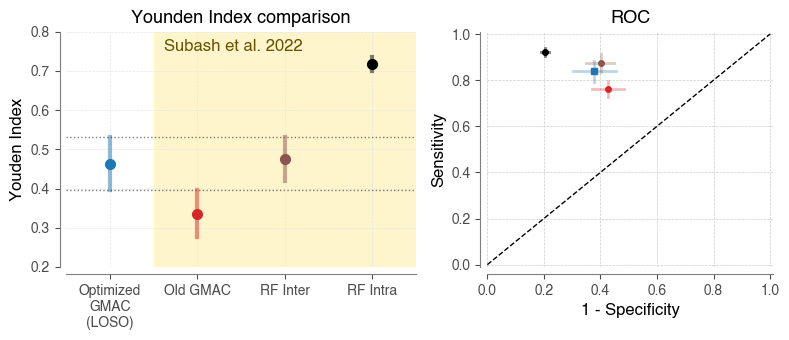

In [49]:
# Combine data from all limbs
lightc = ["#f08181", "#72a3f2", "#ffaf69", "#d2a679", "#ababab", "#b2b266", "#b2b266"]
# darkc = ["#a80a0a", "#002eab", "#bd6e00", "#86592d", "black", "#55552b", "#55552b"]
darkc = ["#a80a0a", "tab:blue", "tab:red", "tab:brown", "black", "#55552b", "#55552b"]
darkc_dict = {f"{i}": c for i, c in enumerate(darkc)}
fig = plt.figure(figsize=(8, 3.5))
gs = gridspec.GridSpec(1, 2, height_ratios=[1], width_ratios=[4.4, 3.6])

# Number of bootstrap samples
means = {}
ci95 = {}
# Find the bootstrap means and CIs.
means["newgmac"], ci95["newgmac"] = compute_bootstrap_mean_ci(losoperf["youden"])
means["oldgmac"], ci95["oldgmac"] = compute_bootstrap_mean_ci(np.hstack([subash_perf_gmac["youden"][i] for i in range(4)]))
means["rfinter"], ci95["rfinter"] = compute_bootstrap_mean_ci(np.hstack([subash_perf_rfinter["youden"][i] for i in range(4)]))
means["rfintra"], ci95["rfintra"] = compute_bootstrap_mean_ci(np.hstack([subash_perf_rfintra["youden"][i] for i in range(4)]))

ax = plt.subplot(gs[0, 0])
# Current performance
j = 1
ax.plot([j-0.], [means["newgmac"]], color=darkc[j], marker="o", markersize=7)
ax.plot([j, j], ci95["newgmac"], color=darkc[j], lw=3, alpha=0.5)
ax.axhline(ci95["newgmac"][0], color="black", alpha=0.5, lw=1, ls="dotted")
ax.axhline(ci95["newgmac"][1], color="black", alpha=0.5, lw=1, ls="dotted")
j = 2
ax.plot([j-0.], [means["oldgmac"]], color=darkc[j], marker="o", markersize=7)
ax.plot([j, j], ci95["oldgmac"], color=darkc[j], lw=3, alpha=0.5)
j = 3
ax.plot([j-0.], [means["rfinter"]], color=darkc[j], marker="o", markersize=7)
ax.plot([j, j], ci95["rfinter"], color=darkc[j], lw=3, alpha=0.5)
j = 4
ax.plot([j-0.], [means["rfintra"]], color=darkc[j], marker="o", markersize=7)
ax.plot([j, j], ci95["rfintra"], color=darkc[j], lw=3, alpha=0.5)

# Backgrounds
background = plt.Rectangle((0.25, 0), 1, 1,
                           transform=ax.transAxes,
                           color='#fff5cc', zorder=-1)
ax.add_patch(background)
ax.text(0.28, 0.97, "Subash et al. 2022", ha="left", va="top", fontsize=12,
        color="#665200", transform=ax.transAxes,)

ax.set_ylim(0.2, 0.8)
ax.set_xlim(0.5, 4.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.9', linestyle='--', linewidth=0.5);
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(
    ["Optimized\nGMAC\n(LOSO)",] +
    ["Old GMAC", "RF Inter", "RF Intra"],
)
ax.set_ylabel("Youden Index", fontsize=12)
ax.set_title("Younden Index comparison", fontsize=13)

# ROC plot
ax = plt.subplot(gs[0, 1])
ax.plot([0, 1], [0, 1], lw=1, color="black", ls="--")
# LOO Optimized GMAC
_valsens = losoperf["sensitivity"]
_valspec = losoperf["specificity"]
_xmean, _xci = compute_bootstrap_mean_ci(losoperf["specificity"])
_ymean, _yci = compute_bootstrap_mean_ci(losoperf["sensitivity"])
ax.plot(1 - _xci, [_ymean, _ymean], color=darkc[1], alpha=0.3, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color=darkc[1], alpha=0.3, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=4, color=darkc[1], alpha=1)

# Old GMAC
_valsens = np.hstack([subash_perf_gmac["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([subash_perf_gmac["specificity"][i] for i in range(4)])
_xmean, _xci = compute_bootstrap_mean_ci(_valspec)
_ymean, _yci = compute_bootstrap_mean_ci(_valsens)
ax.plot(1 - _xci, [_ymean, _ymean], color=darkc[2], alpha=0.3, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color=darkc[2], alpha=0.3, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=4, color=darkc[2], alpha=1)

# RF Inter
_valsens = np.hstack([subash_perf_rfinter["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([subash_perf_rfinter["specificity"][i] for i in range(4)])
_xmean, _xci = compute_bootstrap_mean_ci(_valspec)
_ymean, _yci = compute_bootstrap_mean_ci(_valsens)
ax.plot(1 - _xci, [_ymean, _ymean], color=darkc[3], alpha=0.3, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color=darkc[3], alpha=0.3, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=4, color=darkc[3], alpha=1)

# RF Intra
_valsens = np.hstack([subash_perf_rfintra["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([subash_perf_rfintra["specificity"][i] for i in range(4)])
_xmean, _xci = compute_bootstrap_mean_ci(_valspec)
_ymean, _yci = compute_bootstrap_mean_ci(_valsens)
ax.plot(1 - _xci, [_ymean, _ymean], color=darkc[4], alpha=0.5, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color=darkc[4], alpha=0.5, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=4, color=darkc[4], alpha=1)

ax.set_ylim(-0.01, 1.01)
ax.set_xlim(0.0, 1.01)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.8', linestyle='--', linewidth=0.5);
ax.set_ylabel("Sensitivity", fontsize=12)
ax.set_xlabel("1 - Specificity", fontsize=12)
ax.set_title("ROC", fontsize=13)

plt.tight_layout()

fig.savefig(pathlib.Path(basedir, f"gmac_summary_all_loso.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(basedir, f"gmac_summary_all_loso.svg"), bbox_inches="tight")

### Table of Results

In [124]:
# Generate the result tables for individual subjects and limbs.
subjs = list(gmac_perf["subjtype"].unique())

# Get the performance of the left out subject for the best parameters.
losoperfdf = pd.DataFrame(columns=["subjtype", "subject", "limb", "type",
                                   "youden", "sensitivity", "specificity"])
for i, _subj in enumerate(subjs):
    # Index to leave out.
    _looinx = (gmac_perf.subjtype == _subj)
    # Right/Unaffecred limb
    _limbinx = gmac_perf.limb == ("right" if "H" in _subj else "unaff")
    _inx = ((gmac_perf.np == bestargs[i][0]) &
            (gmac_perf.fc == bestargs[i][1]) &
            (gmac_perf.nc == bestargs[i][2]) &
            (gmac_perf.nam == bestargs[i][3]) &
            (gmac_perf.p_th == bestargs[i][4]) &
            (gmac_perf.p_th_band == bestargs[i][5]) &
            (gmac_perf.am_th == bestargs[i][6]) &
            (gmac_perf.am_th_band == bestargs[i][7]))
    # Computer performance
    _fullinx = _looinx & _inx & _limbinx
    print(i, _subj, gmac_perf[_fullinx]["limb"].values, gmac_perf[_fullinx]["youden"].values)
    _perfdict = {
        "subjtype": [_subj],
        "subject": gmac_perf[_looinx]["subject"].unique(),
        "type": ["healthy" if "H" in _subj else "stroke"],
        "limb": gmac_perf[_fullinx]["limb"].unique(),
        "youden": gmac_perf.loc[_fullinx, "youden"].values,
        "sensitivity": gmac_perf.loc[_fullinx, "sensitivity"].values,
        "specificity": gmac_perf.loc[_fullinx, "specificity"].values,
    }
    losoperfdf = pd.concat([losoperfdf, pd.DataFrame.from_dict(_perfdict)],
                           ignore_index=True)
    # Left/Affected limb
    _limbinx = gmac_perf.limb == ("left" if "H" in _subj else "aff")
    _inx = ((gmac_perf.np == bestargs[i][0]) &
            (gmac_perf.fc == bestargs[i][1]) &
            (gmac_perf.nc == bestargs[i][2]) &
            (gmac_perf.nam == bestargs[i][3]) &
            (gmac_perf.p_th == bestargs[i][4]) &
            (gmac_perf.p_th_band == bestargs[i][5]) &
            (gmac_perf.am_th == bestargs[i][6]) &
            (gmac_perf.am_th_band == bestargs[i][7]))
    # Computer performance
    _fullinx = _looinx & _inx & _limbinx
    print(i, _subj, gmac_perf[_fullinx]["limb"].values, gmac_perf[_fullinx]["youden"].values)
    _perfdict = {
        "subjtype": [_subj],
        "subject": gmac_perf[_looinx]["subject"].unique(),
        "type": ["healthy" if "H" in _subj else "stroke"],
        "limb": gmac_perf[_fullinx]["limb"].unique(),
        "youden": gmac_perf.loc[_fullinx, "youden"].values,
        "sensitivity": gmac_perf.loc[_fullinx, "sensitivity"].values,
        "specificity": gmac_perf.loc[_fullinx, "specificity"].values,
    }
    losoperfdf = pd.concat([losoperfdf, pd.DataFrame.from_dict(_perfdict)],
                           ignore_index=True)
losoperfdf.to_csv(f"{basedir}/losoperfdf.csv")

0 H2 ['right'] [0.4452]
0 H2 ['left'] [0.4549]
1 H3 ['right'] [0.6476]
1 H3 ['left'] [0.3308]
2 H4 ['right'] [0.7035]
2 H4 ['left'] [0.4147]
3 H5 ['right'] [0.721]
3 H5 ['left'] [0.5117]
4 H6 ['right'] [0.5503]
4 H6 ['left'] [0.4963]
5 H7 ['right'] [0.4697]
5 H7 ['left'] [0.3175]
6 H8 ['right'] [0.5047]
6 H8 ['left'] [0.5046]
7 H9 ['right'] [0.8874]
7 H9 ['left'] [0.7621]
8 H10 ['right'] [0.5628]
8 H10 ['left'] [0.4639]
9 H1 ['right'] [0.5132]
9 H1 ['left'] [0.3065]
10 S1 ['unaff'] [0.5033]
10 S1 ['aff'] [0.1495]
11 S2 ['unaff'] [0.6594]
11 S2 ['aff'] [0.2989]
12 S3 ['unaff'] [0.6122]
12 S3 ['aff'] [0.3428]
13 S4 ['unaff'] [0.4558]
13 S4 ['aff'] [0.5445]
14 S5 ['unaff'] [0.2273]
14 S5 ['aff'] [0.6365]


In [51]:
# Healthy - Right
_inx = ((losoperfdf["type"] == "healthy")
        & (losoperfdf["limb"] == "right"))
losoperfdf[_inx]

,subjtype,subject,limb,type,youden,sensitivity,specificity
0,H2,2,right,healthy,0.445169,0.974369,0.470800
2,H3,3,right,healthy,0.647625,0.742781,0.904844
4,H4,4,right,healthy,0.703542,0.961274,0.742268
6,H5,5,right,healthy,0.720958,0.924846,0.796112
8,H6,6,right,healthy,0.550330,0.754857,0.795473
10,H7,7,right,healthy,0.469653,0.889449,0.580205
12,H8,8,right,healthy,0.504681,0.937288,0.567393
14,H9,9,right,healthy,0.887389,0.932808,0.954581
16,H10,10,right,healthy,0.562805,0.938202,0.624603
18,H1,1,right,healthy,0.513236,0.799659,0.713577


In [52]:
# Cols to get
cols = ["subject", "method", "type", "limb", "youden", "sensitivity", "specificity"]
# RF intra Summary DF
subashsummdf = pd.DataFrame(columns=cols)

# Go through all limbs
limbtypes = [("right", "healthy"), ("left", "healthy"), ("unaff", "stroke"), ("aff", "stroke")]
methods = ["GMAC", "RF intra", "RF inter"]
for (_l, _t) in limbtypes:
    for _m in methods:
        _inx1 = subash22df[_l]["method"] == _m
        for _s in subash22df[_l]["subject"].unique():
            _inx2 = _inx1 & (subash22df[_l]["subject"] == _s)
            _perfdict = {
                "subject": [_s],
                "method": [_m],
                "limb": [_l],
                "type": [_t],
                "youden": [np.mean(subash22df[_l][_inx2]["youden"])],
                "sensitivity": [np.mean(subash22df[_l][_inx2]["sensitivity"])],
                "specificity": [np.mean(subash22df[_l][_inx2]["specificity"])],
            }
            subashsummdf = pd.concat([subashsummdf,
                                    pd.DataFrame.from_dict(_perfdict)],
                                    ignore_index=True)
subashsummdf.to_csv(f"{basedir}/subashsummdf.csv")

In [53]:
subash22df["right"]["method"].unique()

array(['Activity Counts', 'Vector Magnitude', 'GM Score', 'GMAC',
       'RF intra', 'RF inter', 'SVM intra', 'SVM inter', 'MLP intra',
       'MLP inter'], dtype=object)

### ROC Plots for GMAC for different parameter combination

In [54]:
import random

In [55]:
# Healthy subject indidces
_subjs = [_s for _s in gmac_perf["subjtype"].unique() if 'H' in _s]
healthy_inx = gmac_perf["subjtype"] == _subjs[0]
for _s in _subjs[1:]:
    healthy_inx = healthy_inx | (gmac_perf["subjtype"] == _s)
_subjs = [_s for _s in gmac_perf["subjtype"].unique() if 'S' in _s]
stroke_inx = gmac_perf["subjtype"] == _subjs[0]
for _s in _subjs[1:]:
    stroke_inx = stroke_inx | (gmac_perf["subjtype"] == _s)

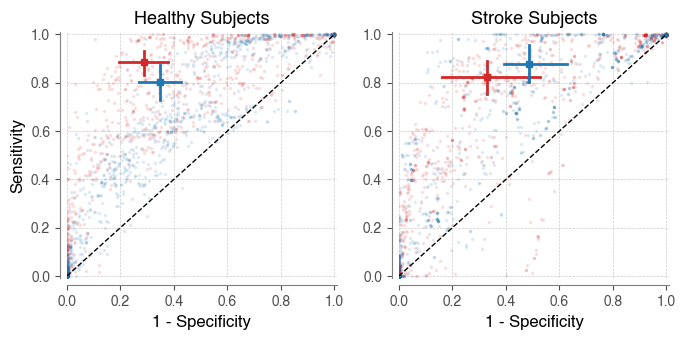

In [56]:
# Figure.
fig = plt.figure(figsize=(7, 3.5))
ax = fig.add_subplot(121)
# Get Sens, and Spec.
# Number of bootstrap samples
means = {}
ci95 = {}

# Find the bootstrap means and CIs.
# Right Limb
_inxhr = ((losoperfdf["type"] == "healthy") &
          (losoperfdf["limb"] == "right"))
_xmean, _xci = compute_bootstrap_mean_ci(losoperfdf[_inxhr]["specificity"].values)
_ymean, _yci = compute_bootstrap_mean_ci(losoperfdf[_inxhr]["sensitivity"].values)
ax.plot(1 - _xci, [_ymean, _ymean], color="tab:red", alpha=1, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color="tab:red", alpha=1, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=4, color="tab:red", alpha=1)

# spec, sens vals
limb_inx = (gmac_perf["limb"] == "right")
N = np.sum(healthy_inx & limb_inx)
_randinx = np.random.choice(N, 1000, replace=False)
_spec = 1 - gmac_perf[healthy_inx & limb_inx]["specificity"].values
_sens = gmac_perf[healthy_inx & limb_inx]["sensitivity"].values
ax.plot(_spec[_randinx], _sens[_randinx], color="tab:red", marker=".", markersize=3,
        alpha=0.1, linestyle="None")

# Left Limb
_inxhr = ((losoperfdf["type"] == "healthy") &
          (losoperfdf["limb"] == "left"))
_xmean, _xci = compute_bootstrap_mean_ci(losoperfdf[_inxhr]["specificity"].values)
_ymean, _yci = compute_bootstrap_mean_ci(losoperfdf[_inxhr]["sensitivity"].values)
ax.plot(1 - _xci, [_ymean, _ymean], color="tab:blue", alpha=1, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color="tab:blue", alpha=1, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=4, color="tab:blue", alpha=1)

# spec, sens vals
limb_inx = (gmac_perf["limb"] == "left")
N = np.sum(healthy_inx & limb_inx)
_randinx = np.random.choice(N, 1000, replace=False)
_spec = 1 - gmac_perf[healthy_inx & limb_inx]["specificity"].values
_sens = gmac_perf[healthy_inx & limb_inx]["sensitivity"].values
ax.plot(_spec[_randinx], _sens[_randinx], color="tab:blue", marker=".", markersize=3,
        alpha=0.1, linestyle="None")
# ax.plot([1 - _xmean], [_ymean], marker="s", ms=4, color="tab:blue", alpha=1)

ax.plot([0, 1], [0, 1], lw=1, color="black", ls="--")
ax.set_ylim(-0.01, 1.01)
ax.set_xlim(0.0, 1.01)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.8', linestyle='--', linewidth=0.5);
ax.set_ylabel("Sensitivity", fontsize=12)
ax.set_xlabel("1 - Specificity", fontsize=12)
ax.set_title("Healthy Subjects", fontsize=13)

ax = fig.add_subplot(122)
# Unaffected Limb
_inxhr = ((losoperfdf["type"] == "stroke") &
          (losoperfdf["limb"] == "unaff"))
_xmean, _xci = compute_bootstrap_mean_ci(losoperfdf[_inxhr]["specificity"].values)
_ymean, _yci = compute_bootstrap_mean_ci(losoperfdf[_inxhr]["sensitivity"].values)
ax.plot(1 - _xci, [_ymean, _ymean], color="tab:red", alpha=1, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color="tab:red", alpha=1, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=4, color="tab:red", alpha=1)

# spec, sens vals
limb_inx = (gmac_perf["limb"] == "unaff")
N = np.sum(stroke_inx & limb_inx)
_randinx = np.random.choice(N, 1000, replace=False)
_spec = 1 - gmac_perf[stroke_inx & limb_inx]["specificity"].values
_sens = gmac_perf[stroke_inx & limb_inx]["sensitivity"].values
ax.plot(_spec[_randinx], _sens[_randinx], color="tab:red", marker=".", markersize=3,
        alpha=0.1, linestyle="None")

# Left Limb
_inxhr = ((losoperfdf["type"] == "stroke") &
          (losoperfdf["limb"] == "aff"))
_xmean, _xci = compute_bootstrap_mean_ci(losoperfdf[_inxhr]["specificity"].values)
_ymean, _yci = compute_bootstrap_mean_ci(losoperfdf[_inxhr]["sensitivity"].values)
ax.plot(1 - _xci, [_ymean, _ymean], color="tab:blue", alpha=1, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color="tab:blue", alpha=1, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=4, color="tab:blue", alpha=1)

# spec, sens vals
limb_inx = (gmac_perf["limb"] == "aff")
N = np.sum(stroke_inx & limb_inx)
_randinx = np.random.choice(N, 1000, replace=False)
_spec = 1 - gmac_perf[stroke_inx & limb_inx]["specificity"].values
_sens = gmac_perf[stroke_inx & limb_inx]["sensitivity"].values
ax.plot(_spec[_randinx], _sens[_randinx], color="tab:blue", marker=".", markersize=3,
        alpha=0.1, linestyle="None")
# ax.plot([1 - _xmean], [_ymean], marker="s", ms=4, color="tab:blue", alpha=1)

ax.plot([0, 1], [0, 1], lw=1, color="black", ls="--")
ax.set_ylim(-0.01, 1.01)
ax.set_xlim(0.0, 1.01)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.8', linestyle='--', linewidth=0.5);
# ax.set_ylabel("Sensitivity", fontsize=12)
ax.set_xlabel("1 - Specificity", fontsize=12)
ax.set_title("Stroke Subjects", fontsize=13)

plt.tight_layout()

fig.savefig(pathlib.Path(basedir, f"ROC_loso.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(basedir, f"ROC_loso.svg"), bbox_inches="tight")

## Extra Plots

In [57]:
subjs = list(set(gmac_perf.subjtype))
subjsh = list(_s for _s in set(gmac_perf.subjtype) if "H" in _s)
subjsp = list(_s for _s in set(gmac_perf.subjtype) if "S" in _s)

# Get the performance of the left out subject for the best parameters.
def _get_dict(n): 
    return {"youden": np.zeros(n),
            "sensitivity": np.zeros(n),
            "specificity": np.zeros(n)}

losoperfh = {
    "left": _get_dict(len(subjsh)),
    "right": _get_dict(len(subjsh)),
}
for i, _subj in enumerate(subjsh):
    for _l in ["left", "right"]:
        # Index to leave out.
        _looinx = ((gmac_perf.subjtype == _subj) &
                   (gmac_perf.limb == _l))
        _inx = ((gmac_perf.np == bestargs[i][0]) &
                (gmac_perf.fc == bestargs[i][1]) &
                (gmac_perf.nc == bestargs[i][2]) &
                (gmac_perf.nam == bestargs[i][3]) &
                (gmac_perf.p_th == bestargs[i][4]) &
                (gmac_perf.p_th_band == bestargs[i][5]) &
                (gmac_perf.am_th == bestargs[i][6]) &
                (gmac_perf.am_th_band == bestargs[i][7]))
        # Computer performance
        losoperfh[_l]["youden"][i] = gmac_perf.loc[_looinx & _inx, "youden"].values[0]
        losoperfh[_l]["sensitivity"][i] = gmac_perf.loc[_looinx & _inx, "sensitivity"].values[0]
        losoperfh[_l]["specificity"][i] = gmac_perf.loc[_looinx & _inx, "specificity"].values[0]

# Get the performance of the left out subject for the best parameters.
losoperfp = {
    "aff": _get_dict(len(subjsp)),
    "unaff": _get_dict(len(subjsp)),
}
for i, _subj in enumerate(subjsp):
    for _l in ["aff", "unaff"]:
        # Index to leave out.
        _looinx = ((gmac_perf.subjtype == _subj) &
                   (gmac_perf.limb == _l))
        _inx = ((gmac_perf.np == bestargs[i][0]) &
                (gmac_perf.fc == bestargs[i][1]) &
                (gmac_perf.nc == bestargs[i][2]) &
                (gmac_perf.nam == bestargs[i][3]) &
                (gmac_perf.p_th == bestargs[i][4]) &
                (gmac_perf.p_th_band == bestargs[i][5]) &
                (gmac_perf.am_th == bestargs[i][6]) &
                (gmac_perf.am_th_band == bestargs[i][7]))
        # Computer performance
        losoperfp[_l]["youden"][i] = gmac_perf.loc[_looinx & _inx, "youden"].values[0]
        losoperfp[_l]["sensitivity"][i] = gmac_perf.loc[_looinx & _inx, "sensitivity"].values[0]
        losoperfp[_l]["specificity"][i] = gmac_perf.loc[_looinx & _inx, "specificity"].values[0]

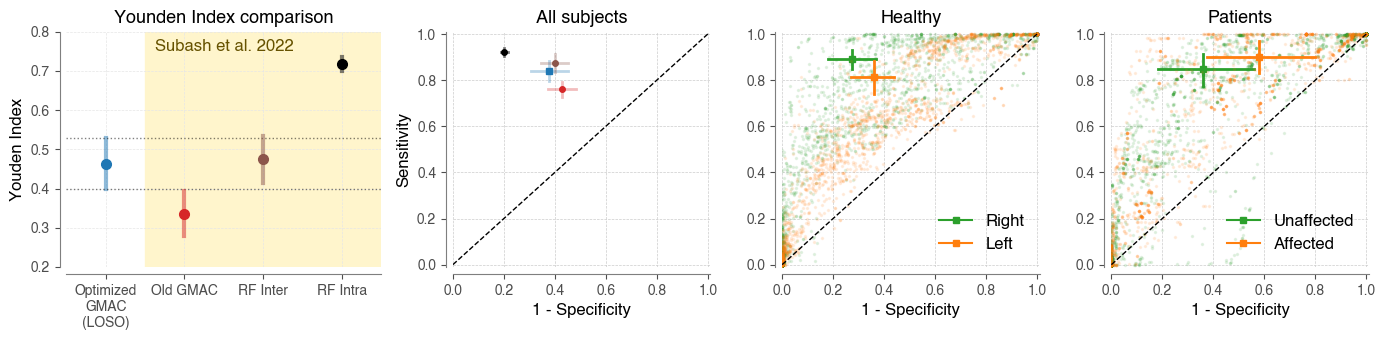

In [73]:
# Combine data from all limbs
lightc = ["#f08181", "#72a3f2", "#ffaf69", "#d2a679", "#ababab", "#b2b266", "#b2b266"]
# darkc = ["#a80a0a", "#002eab", "#bd6e00", "#86592d", "black", "#55552b", "#55552b"]
darkc = ["#a80a0a", "tab:blue", "tab:red", "tab:brown", "black", "#55552b", "#55552b"]
darkc_dict = {f"{i}": c for i, c in enumerate(darkc)}

fig = plt.figure(figsize=(14, 3.5))
gs = gridspec.GridSpec(1, 4, height_ratios=[1], width_ratios=[4.4, 3.6, 3.6, 3.6])

# Number of bootstrap samples
means = {}
ci95 = {}
# Find the bootstrap means and CIs.
means["newgmac"], ci95["newgmac"] = compute_bootstrap_mean_ci(losoperf["youden"])
means["oldgmac"], ci95["oldgmac"] = compute_bootstrap_mean_ci(np.hstack([subash_perf_gmac["youden"][i] for i in range(4)]))
means["rfinter"], ci95["rfinter"] = compute_bootstrap_mean_ci(np.hstack([subash_perf_rfinter["youden"][i] for i in range(4)]))
means["rfintra"], ci95["rfintra"] = compute_bootstrap_mean_ci(np.hstack([subash_perf_rfintra["youden"][i] for i in range(4)]))

ax = plt.subplot(gs[0, 0])
# Current performance
j = 1
ax.plot([j-0.], [means["newgmac"]], color=darkc[j], marker="o", markersize=7)
ax.plot([j, j], ci95["newgmac"], color=darkc[j], lw=3, alpha=0.5)
ax.axhline(ci95["newgmac"][0], color="black", alpha=0.5, lw=1, ls="dotted")
ax.axhline(ci95["newgmac"][1], color="black", alpha=0.5, lw=1, ls="dotted")
j = 2
ax.plot([j-0.], [means["oldgmac"]], color=darkc[j], marker="o", markersize=7)
ax.plot([j, j], ci95["oldgmac"], color=darkc[j], lw=3, alpha=0.5)
j = 3
ax.plot([j-0.], [means["rfinter"]], color=darkc[j], marker="o", markersize=7)
ax.plot([j, j], ci95["rfinter"], color=darkc[j], lw=3, alpha=0.5)
j = 4
ax.plot([j-0.], [means["rfintra"]], color=darkc[j], marker="o", markersize=7)
ax.plot([j, j], ci95["rfintra"], color=darkc[j], lw=3, alpha=0.5)

# Backgrounds
background = plt.Rectangle((0.25, 0), 1, 1,
                           transform=ax.transAxes,
                           color='#fff5cc', zorder=-1)
ax.add_patch(background)
ax.text(0.28, 0.97, "Subash et al. 2022", ha="left", va="top", fontsize=12,
        color="#665200", transform=ax.transAxes,)

ax.set_ylim(0.2, 0.8)
ax.set_xlim(0.5, 4.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.9', linestyle='--', linewidth=0.5);
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(
    ["Optimized\nGMAC\n(LOSO)",] +
    ["Old GMAC", "RF Inter", "RF Intra"],
)
ax.set_ylabel("Youden Index", fontsize=12)
ax.set_title("Younden Index comparison", fontsize=13)

# ROC plot
ax = plt.subplot(gs[0, 1])
ax.plot([0, 1], [0, 1], lw=1, color="black", ls="--")
# LOO Optimized GMAC
_valsens = losoperf["sensitivity"]
_valspec = losoperf["specificity"]
_xmean, _xci = compute_bootstrap_mean_ci(losoperf["specificity"])
_ymean, _yci = compute_bootstrap_mean_ci(losoperf["sensitivity"])
ax.plot(1 - _xci, [_ymean, _ymean], color=darkc[1], alpha=0.3, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color=darkc[1], alpha=0.3, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=4, color=darkc[1], alpha=1)

# Old GMAC
_valsens = np.hstack([subash_perf_gmac["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([subash_perf_gmac["specificity"][i] for i in range(4)])
_xmean, _xci = compute_bootstrap_mean_ci(_valspec)
_ymean, _yci = compute_bootstrap_mean_ci(_valsens)
ax.plot(1 - _xci, [_ymean, _ymean], color=darkc[2], alpha=0.3, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color=darkc[2], alpha=0.3, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=4, color=darkc[2], alpha=1)

# RF Inter
_valsens = np.hstack([subash_perf_rfinter["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([subash_perf_rfinter["specificity"][i] for i in range(4)])
_xmean, _xci = compute_bootstrap_mean_ci(_valspec)
_ymean, _yci = compute_bootstrap_mean_ci(_valsens)
ax.plot(1 - _xci, [_ymean, _ymean], color=darkc[3], alpha=0.3, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color=darkc[3], alpha=0.3, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=4, color=darkc[3], alpha=1)

# RF Intra
_valsens = np.hstack([subash_perf_rfintra["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([subash_perf_rfintra["specificity"][i] for i in range(4)])
_xmean, _xci = compute_bootstrap_mean_ci(_valspec)
_ymean, _yci = compute_bootstrap_mean_ci(_valsens)
ax.plot(1 - _xci, [_ymean, _ymean], color=darkc[4], alpha=0.5, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color=darkc[4], alpha=0.5, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=4, color=darkc[4], alpha=1)

ax.set_ylim(-0.01, 1.01)
ax.set_xlim(0.0, 1.01)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.8', linestyle='--', linewidth=0.5);
ax.set_ylabel("Sensitivity", fontsize=12)
ax.set_xlabel("1 - Specificity", fontsize=12)
ax.set_title("All subjects", fontsize=13)

ax = plt.subplot(gs[0, 2])
# Get Sens, and Spec.
# Number of bootstrap samples
means = {}
ci95 = {}

# Find the bootstrap means and CIs.
# Right Limb
_xmean, _xci = compute_bootstrap_mean_ci(losoperfh["right"]["specificity"])
_ymean, _yci = compute_bootstrap_mean_ci(losoperfh["right"]["sensitivity"])
ax.plot(1 - _xci, [_ymean, _ymean], color="tab:green", alpha=1, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color="tab:green", alpha=1, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=4, color="tab:green", alpha=1, label="Right")

# spec, sens vals
limb_inx = (gmac_perf["limb"] == "right")
N = np.sum(healthy_inx & limb_inx)
_randinx = np.random.choice(N, 2000, replace=False)
_spec = 1 - gmac_perf[healthy_inx & limb_inx]["specificity"].values
_sens = gmac_perf[healthy_inx & limb_inx]["sensitivity"].values
ax.plot(_spec[_randinx], _sens[_randinx], color="tab:green", marker=".", markersize=3,
        alpha=0.1, linestyle="None")

# Left Limb
_xmean, _xci = compute_bootstrap_mean_ci(losoperfh["left"]["specificity"])
_ymean, _yci = compute_bootstrap_mean_ci(losoperfh["left"]["sensitivity"])
ax.plot(1 - _xci, [_ymean, _ymean], color="tab:orange", alpha=1, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color="tab:orange", alpha=1, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=4, color="tab:orange", alpha=1, label="Left")

# spec, sens vals
limb_inx = (gmac_perf["limb"] == "left")
N = np.sum(healthy_inx & limb_inx)
_randinx = np.random.choice(N, 2000, replace=False)
_spec = 1 - gmac_perf[healthy_inx & limb_inx]["specificity"].values
_sens = gmac_perf[healthy_inx & limb_inx]["sensitivity"].values
ax.plot(_spec[_randinx], _sens[_randinx], color="tab:orange", marker=".", markersize=3,
        alpha=0.1, linestyle="None")

ax.plot([0, 1], [0, 1], lw=1, color="black", ls="--")
ax.set_ylim(-0.01, 1.01)
ax.set_xlim(0.0, 1.01)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.8', linestyle='--', linewidth=0.5);
# ax.set_ylabel("Sensitivity", fontsize=12)
ax.set_xlabel("1 - Specificity", fontsize=12)
ax.legend(loc=4, frameon=False, fontsize=12)
ax.set_title("Healthy", fontsize=13)

# ax = fig.add_subplot(122)
ax = plt.subplot(gs[0, 3])
# Unaffected Limb
_xmean, _xci = compute_bootstrap_mean_ci(losoperfp["unaff"]["specificity"])
_ymean, _yci = compute_bootstrap_mean_ci(losoperfp["unaff"]["sensitivity"])
ax.plot(1 - _xci, [_ymean, _ymean], color="tab:green", alpha=1, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color="tab:green", alpha=1, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=4, color="tab:green", alpha=1, label="Unaffected")

# spec, sens vals
limb_inx = (gmac_perf["limb"] == "unaff")
N = np.sum(stroke_inx & limb_inx)
_randinx = np.random.choice(N, 2000, replace=False)
_spec = 1 - gmac_perf[stroke_inx & limb_inx]["specificity"].values
_sens = gmac_perf[stroke_inx & limb_inx]["sensitivity"].values
ax.plot(_spec[_randinx], _sens[_randinx], color="tab:green", marker=".", markersize=3,
        alpha=0.1, linestyle="None")

# Left Limb
_xmean, _xci = compute_bootstrap_mean_ci(losoperfp["aff"]["specificity"])
_ymean, _yci = compute_bootstrap_mean_ci(losoperfp["aff"]["sensitivity"])
ax.plot(1 - _xci, [_ymean, _ymean], color="tab:orange", alpha=1, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color="tab:orange", alpha=1, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=4, color="tab:orange", alpha=1, label="Affected")

# spec, sens vals
limb_inx = (gmac_perf["limb"] == "aff")
N = np.sum(stroke_inx & limb_inx)
_randinx = np.random.choice(N, 2000, replace=False)
_spec = 1 - gmac_perf[stroke_inx & limb_inx]["specificity"].values
_sens = gmac_perf[stroke_inx & limb_inx]["sensitivity"].values
ax.plot(_spec[_randinx], _sens[_randinx], color="tab:orange", marker=".", markersize=3,
        alpha=0.1, linestyle="None")

ax.plot([0, 1], [0, 1], lw=1, color="black", ls="--")
ax.set_ylim(-0.01, 1.01)
ax.set_xlim(0.0, 1.01)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.8', linestyle='--', linewidth=0.5);
ax.set_xlabel("1 - Specificity", fontsize=12)
ax.legend(loc=4, frameon=False, fontsize=12)
ax.set_title("Patients", fontsize=13)

plt.tight_layout()

fig.savefig(pathlib.Path(basedir, f"gmac_summary_all_loso_roc.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(basedir, f"gmac_summary_all_loso_roc.svg"), bbox_inches="tight")

### LME model of performance

In [84]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

In [128]:
summ_perf = pd.DataFrame(columns=["subjid", "limb", "method",
                                  "youden", "sensitivity", "specificity"])

# GMAC
for i, _subj in enumerate(subjs):
    # LOSO perf
    _subjinx = gmac_perf.subjtype == _subj
    _subjid = gmac_perf[_subjinx]["subject"].unique()[0]
    _limbs = gmac_perf[_subjinx]["limb"].unique()
    _arginx = ((gmac_perf.np == bestargs[i][0]) &
                (gmac_perf.fc == bestargs[i][1]) &
                (gmac_perf.nc == bestargs[i][2]) &
                (gmac_perf.nam == bestargs[i][3]) &
                (gmac_perf.p_th == bestargs[i][4]) &
                (gmac_perf.p_th_band == bestargs[i][5]) &
                (gmac_perf.am_th == bestargs[i][6]) &
                (gmac_perf.am_th_band == bestargs[i][7]))
    # Build perf DF
    _baseperdfrow = {"subjid": [_subj],
                     "method": ["GMAC"]}
    for _l in _limbs:
        _limbinx = gmac_perf.limb == _l
        _tempdf = gmac_perf[_subjinx & _limbinx & _arginx]
        print(i, _subj, _tempdf["limb"].values, _tempdf["youden"].values)
        summ_perf = pd.concat(
            [summ_perf,
                pd.DataFrame.from_dict(
                _baseperdfrow |
                {"limb": [_l],
                 "youden": _tempdf["youden"].values,
                 "sensitivity": _tempdf["sensitivity"].values,
                 "specificity": _tempdf["specificity"].values})],
            ignore_index=True
        )

# Old GMAC, RF inter, RF intra
for i, _subj in enumerate(subjs):
    # LOSO perf
    _subjinx = gmac_perf.subjtype == _subj
    _subjid = gmac_perf[_subjinx]["subject"].unique()[0]
    _limbs = gmac_perf[_subjinx]["limb"].unique()
    # Build perf DF
    # Subash perf
    # Old GMAC
    _baseperdfrow = {"subjid": [_subj],
                     "method": ["Old GMAC"]}
    for _l in _limbs:
        _minx = subash22df[_l].method == "GMAC"
        _sinx = (subash22df[_l]["subject"] == _subjid)
        _tempdf = subash22df[_l][_minx & _sinx]
        summ_perf = pd.concat(
            [summ_perf,
                pd.DataFrame.from_dict(
                _baseperdfrow |
                {"limb": [_l],
                 "youden": _tempdf["youden"].values,
                 "sensitivity": _tempdf["sensitivity"].values,
                 "specificity": _tempdf["specificity"].values})],
            ignore_index=True
        )
    # RF inter
    _baseperdfrow = {"subjid": [_subj],
                     "method": ["RF inter"]}
    for _l in _limbs:
        _minx = subash22df[_l].method == "RF inter"
        _sinx = (subash22df[_l]["subject"] == _subjid)
        _tempdf = subash22df[_l][_minx & _sinx]
        summ_perf = pd.concat(
            [summ_perf,
                pd.DataFrame.from_dict(
                _baseperdfrow |
                {"limb": [_l],
                 "youden": _tempdf["youden"].values,
                 "sensitivity": _tempdf["sensitivity"].values,
                 "specificity": _tempdf["specificity"].values})],
            ignore_index=True
        )
    # RF intra
    _baseperdfrow = {"subjid": [_subj],
                     "method": ["RF intra"]}
    for _l in _limbs:
        _minx = subash22df[_l].method == "RF intra"
        _sinx = (subash22df[_l]["subject"] == _subjid)
        _tempdf = subash22df[_l][_minx & _sinx]
        summ_perf = pd.concat(
            [summ_perf,
                pd.DataFrame.from_dict(
                _baseperdfrow |
                {"limb": [_l],
                 "youden": np.nanmean(_tempdf["youden"].values),
                 "sensitivity": np.nanmean(_tempdf["sensitivity"].values),
                 "specificity": np.nanmean(_tempdf["specificity"].values)})],
            ignore_index=True
        )
summ_perf[summ_perf["limb"] == "aff"]

0 H2 ['left'] [0.4549]
0 H2 ['right'] [0.4452]
1 H3 ['left'] [0.3308]
1 H3 ['right'] [0.6476]
2 H4 ['left'] [0.4147]
2 H4 ['right'] [0.7035]
3 H5 ['left'] [0.5117]
3 H5 ['right'] [0.721]
4 H6 ['left'] [0.4963]
4 H6 ['right'] [0.5503]
5 H7 ['left'] [0.3175]
5 H7 ['right'] [0.4697]
6 H8 ['left'] [0.5046]
6 H8 ['right'] [0.5047]
7 H9 ['left'] [0.7621]
7 H9 ['right'] [0.8874]
8 H10 ['left'] [0.4639]
8 H10 ['right'] [0.5628]
9 H1 ['left'] [0.3065]
9 H1 ['right'] [0.5132]
10 S1 ['aff'] [0.1495]
10 S1 ['unaff'] [0.5033]
11 S2 ['aff'] [0.2989]
11 S2 ['unaff'] [0.6594]
12 S3 ['aff'] [0.3428]
12 S3 ['unaff'] [0.6122]
13 S4 ['aff'] [0.5445]
13 S4 ['unaff'] [0.4558]
14 S5 ['aff'] [0.6365]
14 S5 ['unaff'] [0.2273]


,subjid,limb,method,youden,sensitivity,specificity
20,S1,aff,GMAC,0.149497,0.895654,0.253843
22,S2,aff,GMAC,0.298935,0.804431,0.494504
24,S3,aff,GMAC,0.342773,0.759148,0.583625
26,S4,aff,GMAC,0.544500,0.948185,0.596315
28,S5,aff,GMAC,0.636497,1.000000,0.636497
90,S1,aff,Old GMAC,0.232040,0.919540,0.312500
92,S1,aff,RF inter,0.235795,0.657224,0.578571
94,S1,aff,RF intra,0.555990,0.678891,0.877098
96,S2,aff,Old GMAC,0.101004,0.905882,0.195122
98,S2,aff,RF inter,0.201637,0.748273,0.453363


### Pairwise comparison

In [129]:
method_groups = summ_perf.groupby(["method"])

# Genenrate new dataframes with new indices
_newdfs = {
    _name[0]: _group.set_index(["subjid", "limb"])
    for _name, _group in method_groups
}

# Rename columns by keyname
for _name, _df in _newdfs.items():
    _newdfs[_name] = _df.rename(columns={
        "youden": f"youden_{_name}",
        "sensitivity": f"sensitivity_{_name}",
        "specificity": f"specificity_{_name}"
    })
    # Remove method column
    _newdfs[_name] = _newdfs[_name].drop(columns=["method"])

# New DF list
_newdflist = [_df for _k, _df in _newdfs.items()]

# Join dataframes by the index
combdf = _newdflist[0].join(_newdflist[1:])

In [130]:
summ_perf[summ_perf["limb"] == "aff"]

,subjid,limb,method,youden,sensitivity,specificity
20,S1,aff,GMAC,0.149497,0.895654,0.253843
22,S2,aff,GMAC,0.298935,0.804431,0.494504
24,S3,aff,GMAC,0.342773,0.759148,0.583625
26,S4,aff,GMAC,0.544500,0.948185,0.596315
28,S5,aff,GMAC,0.636497,1.000000,0.636497
90,S1,aff,Old GMAC,0.232040,0.919540,0.312500
92,S1,aff,RF inter,0.235795,0.657224,0.578571
94,S1,aff,RF intra,0.555990,0.678891,0.877098
96,S2,aff,Old GMAC,0.101004,0.905882,0.195122
98,S2,aff,RF inter,0.201637,0.748273,0.453363


#### All subjects

In [131]:
outcome = "youden"
# GMAC vs. Old GMAC
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(combdf[f"{outcome}_GMAC"], combdf[f"{outcome}_Old GMAC"])

# Apply a multiple comparisons correction method (e.g., Bonferroni)
alpha = 0.05 / 3
print(f"[Old GMAC], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = combdf[f"{outcome}_GMAC"] - combdf[f"{outcome}_Old GMAC"]
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

# GMAC vs. Rf inter
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(combdf[f"{outcome}_GMAC"], combdf[f"{outcome}_RF inter"])

# Apply a multiple comparisons correction method (e.g., Bonferroni)
print(f"\n[RF inter], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = combdf[f"{outcome}_GMAC"] - combdf[f"{outcome}_RF inter"]
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

# GMAC vs. Rf intra
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(combdf[f"{outcome}_GMAC"], combdf[f"{outcome}_RF intra"])

# Apply a multiple comparisons correction method (e.g., Bonferroni)
print(f"\n[RF intra], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = combdf[f"{outcome}_GMAC"] - combdf[f"{outcome}_RF intra"]
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

[Old GMAC], youden
0.000
0.166 $\pm$ 0.158

[RF inter], youden
Not significant
0.025 $\pm$ 0.108

[RF intra], youden
0.000
-0.217 $\pm$ 0.173


In [132]:
outcome = "sensitivity"
# GMAC vs. Old GMAC
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(combdf[f"{outcome}_GMAC"], combdf[f"{outcome}_Old GMAC"])

# Apply a multiple comparisons correction method (e.g., Bonferroni)
alpha = 0.05 / 3
print(f"[Old GMAC], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = combdf[f"{outcome}_GMAC"] - combdf[f"{outcome}_Old GMAC"]
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

# GMAC vs. Rf inter
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(combdf[f"{outcome}_GMAC"], combdf[f"{outcome}_RF inter"])

# Apply a multiple comparisons correction method (e.g., Bonferroni)
print(f"\n[RF inter], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = combdf[f"{outcome}_GMAC"] - combdf[f"{outcome}_RF inter"]
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

# GMAC vs. Rf intra
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(combdf[f"{outcome}_GMAC"], combdf[f"{outcome}_RF intra"])

# Apply a multiple comparisons correction method (e.g., Bonferroni)
print(f"\n[RF intra], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = combdf[f"{outcome}_GMAC"] - combdf[f"{outcome}_RF intra"]
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

[Old GMAC], sensitivity
0.001
0.087 $\pm$ 0.127

[RF inter], sensitivity
Not significant
-0.027 $\pm$ 0.153

[RF intra], sensitivity
Not significant
-0.071 $\pm$ 0.200


In [133]:
outcome = "specificity"
# GMAC vs. Old GMAC
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(combdf[f"{outcome}_GMAC"], combdf[f"{outcome}_Old GMAC"])

# Apply a multiple comparisons correction method (e.g., Bonferroni)
alpha = 0.05 / 3
print(f"[Old GMAC], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = combdf[f"{outcome}_GMAC"] - combdf[f"{outcome}_Old GMAC"]
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

# GMAC vs. Rf inter
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(combdf[f"{outcome}_GMAC"], combdf[f"{outcome}_RF inter"])

# Apply a multiple comparisons correction method (e.g., Bonferroni)
print(f"\n[RF inter], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = combdf[f"{outcome}_GMAC"] - combdf[f"{outcome}_RF inter"]
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

# GMAC vs. Rf intra
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(combdf[f"{outcome}_GMAC"], combdf[f"{outcome}_RF intra"])

# Apply a multiple comparisons correction method (e.g., Bonferroni)
print(f"\n[RF intra], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = combdf[f"{outcome}_GMAC"] - combdf[f"{outcome}_RF intra"]
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

[Old GMAC], specificity
Not significant
0.079 $\pm$ 0.168

[RF inter], specificity
Not significant
0.052 $\pm$ 0.148

[RF intra], specificity
0.000
-0.146 $\pm$ 0.176


#### Healthy or Hemiparetic Participants

In [139]:
# subjinx = [f"H{i}" for i in range(1, 11, 1)]
subjinx = [f"S{i}" for i in range(1, 6, 1)]
subj_type = "Healthy" if subjinx[0][0] == "H" else "Patient"

In [143]:
print(combdf.loc[(subjinx,),"youden_GMAC"])
print(combdf.loc[(subjinx,),"youden_Old GMAC"])

subjid  limb 
S1      aff      0.149497
        unaff    0.503323
S2      aff      0.298935
        unaff    0.659381
S3      aff      0.342773
        unaff    0.612160
S4      aff      0.544500
        unaff    0.455782
S5      aff      0.636497
        unaff    0.227269
Name: youden_GMAC, dtype: float64
subjid  limb 
S1      aff      0.232040
        unaff    0.644383
S2      aff      0.101004
        unaff    0.461753
S3      aff      0.032581
        unaff    0.428332
S4      aff      0.259829
        unaff    0.687375
S5      aff      0.468564
        unaff    0.510975
Name: youden_Old GMAC, dtype: float64


In [145]:
outcome = "youden"

# Print healthy or patient
print(subj_type)

# GMAC vs. Old GMAC
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(combdf.loc[(subjinx,),f"{outcome}_GMAC"], combdf.loc[(subjinx,),f"{outcome}_Old GMAC"])

# Apply a multiple comparisons correction method (e.g., Bonferroni)
alpha = 0.05 / 3
print(f"[Old GMAC], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = combdf.loc[(subjinx,),f"{outcome}_GMAC"] - combdf.loc[(subjinx,),f"{outcome}_Old GMAC"]
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

# GMAC vs. Rf inter
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(combdf.loc[(subjinx,),f"{outcome}_GMAC"], combdf.loc[(subjinx,),f"{outcome}_RF inter"])

# Apply a multiple comparisons correction method (e.g., Bonferroni)
print(f"\n[RF inter], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = combdf.loc[(subjinx,),f"{outcome}_GMAC"] - combdf.loc[(subjinx,),f"{outcome}_RF inter"]
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

# GMAC vs. Rf intra
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(combdf.loc[(subjinx,),f"{outcome}_GMAC"], combdf.loc[(subjinx,),f"{outcome}_RF intra"])

# Apply a multiple comparisons correction method (e.g., Bonferroni)
print(f"\n[RF intra], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = combdf.loc[(subjinx,),f"{outcome}_GMAC"] - combdf.loc[(subjinx,),f"{outcome}_RF intra"]
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

Patient
[Old GMAC], youden
Not significant
0.060 $\pm$ 0.210

[RF inter], youden
Not significant
0.030 $\pm$ 0.143

[RF intra], youden
Not significant
-0.228 $\pm$ 0.246


In [146]:
outcome = "sensitivity"

# Print healthy or patient
print(subj_type)

# GMAC vs. Old GMAC
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(combdf.loc[(subjinx,),f"{outcome}_GMAC"], combdf.loc[(subjinx,),f"{outcome}_Old GMAC"])

# Apply a multiple comparisons correction method (e.g., Bonferroni)
alpha = 0.05 / 3
print(f"[Old GMAC], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = combdf.loc[(subjinx,),f"{outcome}_GMAC"] - combdf.loc[(subjinx,),f"{outcome}_Old GMAC"]
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

# GMAC vs. Rf inter
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(combdf.loc[(subjinx,),f"{outcome}_GMAC"], combdf.loc[(subjinx,),f"{outcome}_RF inter"])

# Apply a multiple comparisons correction method (e.g., Bonferroni)
print(f"\n[RF inter], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = combdf.loc[(subjinx,),f"{outcome}_GMAC"] - combdf.loc[(subjinx,),f"{outcome}_RF inter"]
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

# GMAC vs. Rf intra
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(combdf.loc[(subjinx,),f"{outcome}_GMAC"], combdf.loc[(subjinx,),f"{outcome}_RF intra"])

# Apply a multiple comparisons correction method (e.g., Bonferroni)
print(f"\n[RF intra], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = combdf.loc[(subjinx,),f"{outcome}_GMAC"] - combdf.loc[(subjinx,),f"{outcome}_RF intra"]
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

Patient
[Old GMAC], sensitivity
Not significant
0.054 $\pm$ 0.142

[RF inter], sensitivity
Not significant
0.037 $\pm$ 0.187

[RF intra], sensitivity
Not significant
0.017 $\pm$ 0.296


In [147]:
outcome = "specificity"

# Print healthy or patient
print(subj_type)

# GMAC vs. Old GMAC
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(combdf.loc[(subjinx,),f"{outcome}_GMAC"], combdf.loc[(subjinx,),f"{outcome}_Old GMAC"])

# Apply a multiple comparisons correction method (e.g., Bonferroni)
alpha = 0.05 / 3
print(f"[Old GMAC], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = combdf.loc[(subjinx,),f"{outcome}_GMAC"] - combdf.loc[(subjinx,),f"{outcome}_Old GMAC"]
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

# GMAC vs. Rf inter
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(combdf.loc[(subjinx,),f"{outcome}_GMAC"], combdf.loc[(subjinx,),f"{outcome}_RF inter"])

# Apply a multiple comparisons correction method (e.g., Bonferroni)
print(f"\n[RF inter], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = combdf.loc[(subjinx,),f"{outcome}_GMAC"] - combdf.loc[(subjinx,),f"{outcome}_RF inter"]
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

# GMAC vs. Rf intra
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(combdf.loc[(subjinx,),f"{outcome}_GMAC"], combdf.loc[(subjinx,),f"{outcome}_RF intra"])

# Apply a multiple comparisons correction method (e.g., Bonferroni)
print(f"\n[RF intra], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = combdf.loc[(subjinx,),f"{outcome}_GMAC"] - combdf.loc[(subjinx,),f"{outcome}_RF intra"]
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

Patient
[Old GMAC], specificity
Not significant
0.006 $\pm$ 0.231

[RF inter], specificity
Not significant
-0.007 $\pm$ 0.209

[RF intra], specificity
0.005
-0.245 $\pm$ 0.199


# Intersubject LOSO: Healthy Only

# Healthy Subject Inter-subject GMAC Model with validation (Leave-One-Subject)

In [ ]:
# Leave-one-out validation
subjs = list(_s for _s in set(gmac_perf.subjtype) if "H" in _s)
# subjs = list(_s for _s in set(gmac_perf.subjtype) if "S" in _s)

# Get performance for the different parameters combinations.
_keys = ["np", "fc", "nc", "nam", "p_th", "p_th_band", "am_th", "am_th_band"]
lens = [len(subjs)] + [len(gmac_param_ranges[_k]) for _k in _keys]
perf_loso = np.zeros(lens)
med = np.zeros(lens)
iqr = np.zeros(lens)

# All parameter combinations.
param_combs_enum = list(misc.generate_param_combinations_gmac_wenum(gmac_param_ranges))
for l, _subj in enumerate(subjs):
    # Index to leave out.
    _losoinx = ~(gmac_perf.subjtype == _subj)
    # Generate data for heatmap
    for i, pcvalenum in enumerate(param_combs_enum):
        _ix, _pcval = pcvalenum
        # Go through all limbs
        _inx = ((gmac_perf.np == _pcval["np"]) &
                (gmac_perf.fc == _pcval["fc"]) &
                (gmac_perf.nc == _pcval["nc"]) &
                (gmac_perf.nam == _pcval["nam"]) &
                (gmac_perf.am_th == _pcval["am_th"]) &
                (gmac_perf.am_th_band == _pcval["am_th_band"]) &
                (gmac_perf.p_th == _pcval["p_th"]) &
                (gmac_perf.p_th_band == _pcval["p_th_band"]))
        _vals = gmac_perf.loc[_losoinx & _inx, "youden"].values
        _ixstr = [f"{k}: {v:2d}" for k, v in _ix.items()]
        sys.stdout.write(f"\r{l:2d} {i:5d} {', '.join(_ixstr)}")
        sys.stdout.flush()
        # Compute the cost.
        # Compute performance.
        _perfs = [np.percentile(_vals, q) for q in [25, 50, 75]]
        _i = tuple([l]) + tuple(_ix[_k] for _k in _keys)
        perf_loso[_i] = _perfs[1] * (1 - (_perfs[2] - _perfs[0]))
        med[_i] = _perfs[1]
        iqr[_i] = _perfs[2] - _perfs[0]

# Save the perf data as a numpy file
np.save(pathlib.Path(basedir, "all_perf_loso_healthy.npy"), perf_loso)

14 15389 np:  2, fc:  2, nc:  1, nam:  2, p_th: 18, p_th_band:  4, am_th:  2, am_th_band:  0

In [ ]:
maxinx = np.array([np.where(_perf == np.max(_perf)) for _perf in perf_loso]).T[0].T
bestargs = [
    [
        gmac_param_ranges["np"][_mx[0]],
        gmac_param_ranges["fc"][_mx[1]],
        gmac_param_ranges["nc"][_mx[2]],
        gmac_param_ranges["nam"][_mx[3]],
        gmac_param_ranges["p_th"][_mx[4]],
        gmac_param_ranges["p_th_band"][_mx[5]],
        gmac_param_ranges["am_th"][_mx[6]],
        gmac_param_ranges["am_th_band"][_mx[7]]
    ] for _mx in maxinx
]
bestargs

[[50, 0.01, 4, 25, 10, 40, 0.1, 0],
 [50, 0.01, 4, 25, 10, 40, 0.1, 0],
 [50, 0.01, 4, 25, 10, 60, 0.1, 0],
 [50, 0.01, 4, 25, 10, 40, 0.1, 0],
 [50, 0.01, 4, 25, 10, 40, 0.1, 0],
 [50, 0.01, 2, 25, 10, 40, 0.1, 0],
 [25, 0.01, 4, 25, 10, 60, 0.1, 0],
 [50, 0.01, 4, 25, 10, 40, 0.1, 0],
 [25, 0.01, 4, 50, 10, 60, 0.1, 0],
 [50, 0.01, 4, 25, 10, 40, 0.1, 0],
 [50, 0.01, 4, 25, 10, 40, 0.1, 0],
 [50, 0.01, 4, 25, 10, 40, 0.1, 0],
 [50, 0.01, 2, 25, 10, 40, 0.1, 0],
 [50, 0.01, 2, 25, 10, 40, 0.1, 0],
 [25, 0.01, 4, 25, 10, 60, 0.1, 0]]

In [ ]:
# Get the performance of the left out subject for the best parameters.
losoperf = {
    "youden": np.zeros(2 * len(subjs)),
    "sensitivity": np.zeros(2 * len(subjs)),
    "specificity": np.zeros(2 * len(subjs)),
}
# for i, (_lmb, _subj) in enumerate(subjs):
for i, _subj in enumerate(subjs):
    # Index to leave out.
    _looinx = (gmac_perf.subjtype == _subj)
    _inx = ((gmac_perf.np == bestargs[i][0]) &
            (gmac_perf.fc == bestargs[i][1]) &
            (gmac_perf.nc == bestargs[i][2]) &
            (gmac_perf.nam == bestargs[i][3]) &
            (gmac_perf.p_th == bestargs[i][4]) &
            (gmac_perf.p_th_band == bestargs[i][5]) &
            (gmac_perf.am_th == bestargs[i][6]) &
            (gmac_perf.am_th_band == bestargs[i][7]))
    # Computer performance
    losoperf["youden"][2 * i] = gmac_perf.loc[_looinx & _inx, "youden"].values[0]
    losoperf["youden"][2 * i + 1] = gmac_perf.loc[_looinx & _inx, "youden"].values[1]
    losoperf["sensitivity"][2 * i] = gmac_perf.loc[_looinx & _inx, "sensitivity"].values[0]
    losoperf["sensitivity"][2 * i + 1] = gmac_perf.loc[_looinx & _inx, "sensitivity"].values[1]
    losoperf["specificity"][2 * i] = gmac_perf.loc[_looinx & _inx, "specificity"].values[0]
    losoperf["specificity"][2 * i + 1] = gmac_perf.loc[_looinx & _inx, "specificity"].values[1]

#### Comparing performance with Subash et al. 2022

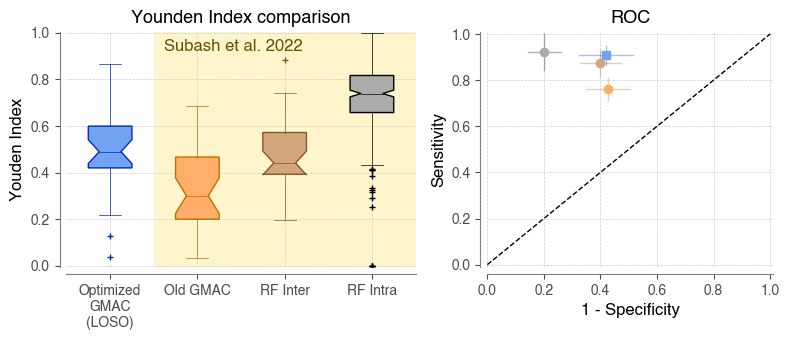

In [ ]:
# Combine data from all limbs
lightc = ["#f08181", "#72a3f2", "#ffaf69", "#d2a679", "#ababab", "#b2b266", "#b2b266"]
darkc = ["#a80a0a", "#002eab", "#bd6e00", "#86592d", "black", "#55552b", "#55552b"]
fig = plt.figure(figsize=(8, 3.5))
gs = gridspec.GridSpec(1, 2, height_ratios=[1], width_ratios=[4.4, 3.6])
ax = plt.subplot(gs[0, 0])

# Current performance
j = 1
ax.boxplot(x=losoperf["youden"], positions=[j],
           widths=0.5, notch=True, patch_artist=True,
           boxprops=dict(facecolor=lightc[j], color=darkc[j], alpha=1.0),
           capprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           whiskerprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           flierprops=dict(color=darkc[j], markeredgecolor=darkc[j],
                           markerfacecolor=darkc[j], marker='+', markersize=4),
           medianprops=dict(color=darkc[j], alpha=1.0, lw=0.5))

# Previous performance
# GMAC
j = 2
_vals = np.hstack([subash_perf_gmac["youden"][i] for i in range(4)])
ax.boxplot(x=_vals, positions=[j],
           widths=0.5, notch=True, patch_artist=True,
           boxprops=dict(facecolor=lightc[j], color=darkc[j], alpha=1.0),
           capprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           whiskerprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           flierprops=dict(color=darkc[j], markeredgecolor=darkc[j],
                           markerfacecolor=darkc[j], marker='+', markersize=4),
           medianprops=dict(color=darkc[j], alpha=1.0, lw=0.5))
# RF INTER
j = 3
_vals = np.hstack([subash_perf_rfinter["youden"][i] for i in range(4)])
ax.boxplot(x=_vals, positions=[j],
           widths=0.5, notch=True, patch_artist=True,
           boxprops=dict(facecolor=lightc[j], color=darkc[j], alpha=1.0),
           capprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           whiskerprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           flierprops=dict(color=darkc[j], markeredgecolor=darkc[j],
                           markerfacecolor=darkc[j], marker='+', markersize=4),
           medianprops=dict(color=darkc[j], alpha=1.0, lw=0.5))
# RF INTRA
j = 4
_vals = np.hstack([subash_perf_rfintra["youden"][i] for i in range(4)])
_vals = _vals[~np.isnan(_vals)]
ax.boxplot(x=_vals, positions=[j],
           widths=0.5, notch=True, patch_artist=True,
           boxprops=dict(facecolor=lightc[j], color=darkc[j], alpha=1.0),
           capprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           whiskerprops=dict(color=darkc[j], alpha=1.0, lw=0.5),
           flierprops=dict(color=darkc[j], markeredgecolor=darkc[j],
                           markerfacecolor=darkc[j], marker='+', markersize=4),
           medianprops=dict(color=darkc[j], alpha=1.0, lw=0.5))
# Backgrounds
background = plt.Rectangle((0.25, 0), 1, 1,
                           transform=ax.transAxes,
                           color='#fff5cc', zorder=-1)
ax.add_patch(background)
ax.text(0.28, 0.97, "Subash et al. 2022", ha="left", va="top", fontsize=12,
        color="#665200", transform=ax.transAxes,)

ax.set_ylim(-0.005, 1.005)
ax.set_xlim(0.5, 4.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.8', linestyle='--', linewidth=0.5);
ax.set_xticklabels(
    ["Optimized\nGMAC\n(LOSO)",] +
    ["Old GMAC", "RF Inter", "RF Intra"],
)
ax.set_ylabel("Youden Index", fontsize=12)
ax.set_title("Younden Index comparison", fontsize=13)

# ROC plot
ax = plt.subplot(gs[0, 1])
ax.plot([0, 1], [0, 1], lw=1, color="black", ls="--")
# LOO Optimized GMAC
_valsens = losoperf["sensitivity"]
_valspec = losoperf["specificity"]
_xmean, _ymean = np.mean(_valspec), np.mean(_valsens)
_xstd, _ystd = np.std(_valspec), np.std(_valsens)
ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
        [_ymean, _ymean], color=darkc[1], alpha=0.3, lw=1)
ax.plot([1 - _xmean, 1 - _xmean],
        [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[1], alpha=0.3, lw=1)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=6, color=lightc[1], alpha=1)

# Old GMAC
_valsens = np.hstack([subash_perf_gmac["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([subash_perf_gmac["specificity"][i] for i in range(4)])
_xmean, _ymean = np.mean(_valspec), np.mean(_valsens)
_xstd, _ystd = np.std(_valspec), np.std(_valsens)
ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
        [_ymean, _ymean], color=darkc[2], alpha=0.3, lw=1)
ax.plot([1 - _xmean, 1 - _xmean],
        [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[2], alpha=0.3, lw=1)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=6, color=lightc[2], alpha=1)
# RF Inter
_valsens = np.hstack([subash_perf_rfinter["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([subash_perf_rfinter["specificity"][i] for i in range(4)])
_xmean, _ymean = np.mean(_valspec), np.mean(_valsens)
_xstd, _ystd = np.std(_valspec), np.std(_valsens)
ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
        [_ymean, _ymean], color=darkc[3], alpha=0.3, lw=1)
ax.plot([1 - _xmean, 1 - _xmean],
        [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[3], alpha=0.3, lw=1)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=6, color=lightc[3], alpha=1)
# RF Intra
_valsens = np.hstack([subash_perf_rfintra["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([subash_perf_rfintra["specificity"][i] for i in range(4)])
_xmean, _ymean = np.nanmean(_valspec), np.nanmean(_valsens)
_xstd, _ystd = np.nanstd(_valspec), np.nanstd(_valsens)
ax.plot([1 - _xmean - 0.5 * _xstd, 1 - _xmean + 0.5 * _xstd],
        [_ymean, _ymean], color=darkc[4], alpha=0.3, lw=1)
ax.plot([1 - _xmean, 1 - _xmean],
        [_ymean - 0.5 * _ystd, _ymean + 0.5 * _ystd], color=darkc[4], alpha=0.3, lw=1)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=6, color=lightc[4], alpha=1)
ax.set_ylim(-0.01, 1.01)
ax.set_xlim(0.0, 1.01)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.8', linestyle='--', linewidth=0.5);
ax.set_ylabel("Sensitivity", fontsize=12)
ax.set_xlabel("1 - Specificity", fontsize=12)
ax.set_title("ROC", fontsize=13)

plt.tight_layout()

fig.savefig(pathlib.Path(basedir, "gmac_summary_all_med_loso.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(basedir, "gmac_summary_all_med_loso.svg"), bbox_inches="tight")

#### Comparing performance with Subash et al. 2022 (means, CIs)

In [ ]:
def compute_bootstrap_mean_ci(rawdata, n_bootstrap_samples=1000):
    # Find the bootstrap means and CIs.
    bootstrap_means = np.zeros(n_bootstrap_samples)
    for i in range(n_bootstrap_samples):
        bootstrap_sample = np.random.choice(rawdata, size=len(rawdata), replace=True)
        bootstrap_means[i] = np.mean(bootstrap_sample)
    return (np.nanmean(bootstrap_means),
            np.nanpercentile(bootstrap_means, [2.5, 97.5]))

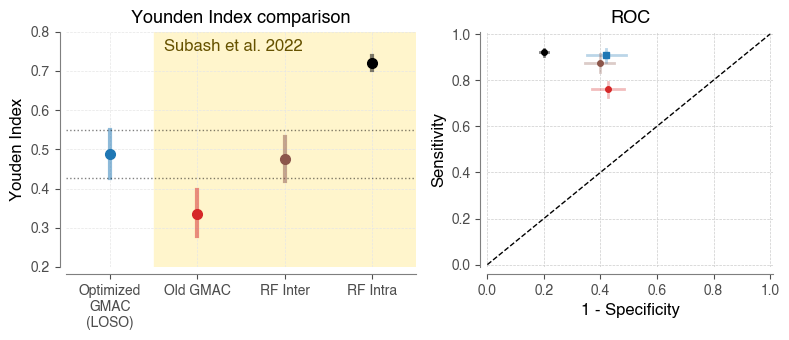

In [ ]:
# Combine data from all limbs
lightc = ["#f08181", "#72a3f2", "#ffaf69", "#d2a679", "#ababab", "#b2b266", "#b2b266"]
# darkc = ["#a80a0a", "#002eab", "#bd6e00", "#86592d", "black", "#55552b", "#55552b"]
darkc = ["#a80a0a", "tab:blue", "tab:red", "tab:brown", "black", "#55552b", "#55552b"]
darkc_dict = {f"{i}": c for i, c in enumerate(darkc)}
fig = plt.figure(figsize=(8, 3.5))
gs = gridspec.GridSpec(1, 2, height_ratios=[1], width_ratios=[4.4, 3.6])

# Number of bootstrap samples
means = {}
ci95 = {}
# Find the bootstrap means and CIs.
means["newgmac"], ci95["newgmac"] = compute_bootstrap_mean_ci(losoperf["youden"])
means["oldgmac"], ci95["oldgmac"] = compute_bootstrap_mean_ci(np.hstack([subash_perf_gmac["youden"][i] for i in range(4)]))
means["rfinter"], ci95["rfinter"] = compute_bootstrap_mean_ci(np.hstack([subash_perf_rfinter["youden"][i] for i in range(4)]))
means["rfintra"], ci95["rfintra"] = compute_bootstrap_mean_ci(np.hstack([subash_perf_rfintra["youden"][i] for i in range(4)]))

ax = plt.subplot(gs[0, 0])
# Current performance
j = 1
ax.plot([j-0.], [means["newgmac"]], color=darkc[j], marker="o", markersize=7)
ax.plot([j, j], ci95["newgmac"], color=darkc[j], lw=3, alpha=0.5)
ax.axhline(ci95["newgmac"][0], color="black", alpha=0.5, lw=1, ls="dotted")
ax.axhline(ci95["newgmac"][1], color="black", alpha=0.5, lw=1, ls="dotted")
j = 2
ax.plot([j-0.], [means["oldgmac"]], color=darkc[j], marker="o", markersize=7)
ax.plot([j, j], ci95["oldgmac"], color=darkc[j], lw=3, alpha=0.5)
j = 3
ax.plot([j-0.], [means["rfinter"]], color=darkc[j], marker="o", markersize=7)
ax.plot([j, j], ci95["rfinter"], color=darkc[j], lw=3, alpha=0.5)
j = 4
ax.plot([j-0.], [means["rfintra"]], color=darkc[j], marker="o", markersize=7)
ax.plot([j, j], ci95["rfintra"], color=darkc[j], lw=3, alpha=0.5)

# Backgrounds
background = plt.Rectangle((0.25, 0), 1, 1,
                           transform=ax.transAxes,
                           color='#fff5cc', zorder=-1)
ax.add_patch(background)
ax.text(0.28, 0.97, "Subash et al. 2022", ha="left", va="top", fontsize=12,
        color="#665200", transform=ax.transAxes,)

ax.set_ylim(0.2, 0.8)
ax.set_xlim(0.5, 4.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.9', linestyle='--', linewidth=0.5);
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(
    ["Optimized\nGMAC\n(LOSO)",] +
    ["Old GMAC", "RF Inter", "RF Intra"],
)
ax.set_ylabel("Youden Index", fontsize=12)
ax.set_title("Younden Index comparison", fontsize=13)

# ROC plot
ax = plt.subplot(gs[0, 1])
ax.plot([0, 1], [0, 1], lw=1, color="black", ls="--")
# LOO Optimized GMAC
_valsens = losoperf["sensitivity"]
_valspec = losoperf["specificity"]
_xmean, _xci = compute_bootstrap_mean_ci(losoperf["specificity"])
_ymean, _yci = compute_bootstrap_mean_ci(losoperf["sensitivity"])
ax.plot(1 - _xci, [_ymean, _ymean], color=darkc[1], alpha=0.3, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color=darkc[1], alpha=0.3, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=4, color=darkc[1], alpha=1)

# Old GMAC
_valsens = np.hstack([subash_perf_gmac["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([subash_perf_gmac["specificity"][i] for i in range(4)])
_xmean, _xci = compute_bootstrap_mean_ci(_valspec)
_ymean, _yci = compute_bootstrap_mean_ci(_valsens)
ax.plot(1 - _xci, [_ymean, _ymean], color=darkc[2], alpha=0.3, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color=darkc[2], alpha=0.3, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=4, color=darkc[2], alpha=1)

# RF Inter
_valsens = np.hstack([subash_perf_rfinter["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([subash_perf_rfinter["specificity"][i] for i in range(4)])
_xmean, _xci = compute_bootstrap_mean_ci(_valspec)
_ymean, _yci = compute_bootstrap_mean_ci(_valsens)
ax.plot(1 - _xci, [_ymean, _ymean], color=darkc[3], alpha=0.3, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color=darkc[3], alpha=0.3, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=4, color=darkc[3], alpha=1)

# RF Intra
_valsens = np.hstack([subash_perf_rfintra["sensitivity"][i] for i in range(4)])
_valspec = np.hstack([subash_perf_rfintra["specificity"][i] for i in range(4)])
_xmean, _xci = compute_bootstrap_mean_ci(_valspec)
_ymean, _yci = compute_bootstrap_mean_ci(_valsens)
ax.plot(1 - _xci, [_ymean, _ymean], color=darkc[4], alpha=0.5, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color=darkc[4], alpha=0.5, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="o", ms=4, color=darkc[4], alpha=1)

ax.set_ylim(-0.01, 1.01)
ax.set_xlim(0.0, 1.01)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.8', linestyle='--', linewidth=0.5);
ax.set_ylabel("Sensitivity", fontsize=12)
ax.set_xlabel("1 - Specificity", fontsize=12)
ax.set_title("ROC", fontsize=13)

plt.tight_layout()

fig.savefig(pathlib.Path(basedir, "gmac_summary_all_loso.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(basedir, "gmac_summary_all_loso.svg"), bbox_inches="tight")

### Table of Results

In [ ]:
# Generate the result tables for individual subjects and limbs.
subjs = list(gmac_perf["subjtype"].unique())

# Get the performance of the left out subject for the best parameters.
losoperfdf = pd.DataFrame(columns=["subjtype", "subject", "limb", "type",
                                   "youden", "sensitivity", "specificity"])
for i, _subj in enumerate(subjs):
    # Index to leave out.
    _looinx = (gmac_perf.subjtype == _subj)
    # Right/Unaffecred limb
    _limbinx = gmac_perf.limb == ("right" if "H" in _subj else "unaff")
    _inx = ((gmac_perf.np == bestargs[i][0]) &
            (gmac_perf.fc == bestargs[i][1]) &
            (gmac_perf.nc == bestargs[i][2]) &
            (gmac_perf.nam == bestargs[i][3]) &
            (gmac_perf.p_th == bestargs[i][4]) &
            (gmac_perf.p_th_band == bestargs[i][5]) &
            (gmac_perf.am_th == bestargs[i][6]) &
            (gmac_perf.am_th_band == bestargs[i][7]))
    # Computer performance
    _fullinx = _looinx & _inx & _limbinx
    _perfdict = {
        "subjtype": [_subj],
        "subject": gmac_perf[_looinx]["subject"].unique(),
        "type": ["healthy" if "H" in _subj else "stroke"],
        "limb": gmac_perf[_fullinx]["limb"].unique(),
        "youden": gmac_perf.loc[_fullinx, "youden"].values,
        "sensitivity": gmac_perf.loc[_fullinx, "sensitivity"].values,
        "specificity": gmac_perf.loc[_fullinx, "specificity"].values,
    }
    losoperfdf = pd.concat([losoperfdf, pd.DataFrame.from_dict(_perfdict)],
                           ignore_index=True)
    # Left/Affecred limb
    _limbinx = gmac_perf.limb == ("left" if "H" in _subj else "aff")
    _inx = ((gmac_perf.np == bestargs[i][0]) &
            (gmac_perf.fc == bestargs[i][1]) &
            (gmac_perf.nc == bestargs[i][2]) &
            (gmac_perf.nam == bestargs[i][3]) &
            (gmac_perf.p_th == bestargs[i][4]) &
            (gmac_perf.p_th_band == bestargs[i][5]) &
            (gmac_perf.am_th == bestargs[i][6]) &
            (gmac_perf.am_th_band == bestargs[i][7]))
    # Computer performance
    _fullinx = _looinx & _inx & _limbinx
    _perfdict = {
        "subjtype": [_subj],
        "subject": gmac_perf[_looinx]["subject"].unique(),
        "type": ["healthy" if "H" in _subj else "stroke"],
        "limb": gmac_perf[_fullinx]["limb"].unique(),
        "youden": gmac_perf.loc[_fullinx, "youden"].values,
        "sensitivity": gmac_perf.loc[_fullinx, "sensitivity"].values,
        "specificity": gmac_perf.loc[_fullinx, "specificity"].values,
    }
    losoperfdf = pd.concat([losoperfdf, pd.DataFrame.from_dict(_perfdict)],
                           ignore_index=True)
losoperfdf.to_csv(f"{basedir}/losoperfdf.csv")

In [ ]:
# Healthy - Right
_inx = ((losoperfdf["type"] == "healthy")
        & (losoperfdf["limb"] == "right"))
losoperfdf[_inx]

,subjtype,subject,limb,type,youden,sensitivity,specificity
0,H2,2,right,healthy,0.449952,0.974857,0.475094
2,H3,3,right,healthy,0.756938,0.862428,0.894510
4,H4,4,right,healthy,0.708185,0.963141,0.745044
6,H5,5,right,healthy,0.686290,0.891924,0.794367
8,H6,6,right,healthy,0.550163,0.754690,0.795473
10,H7,7,right,healthy,0.477791,0.888150,0.589641
12,H8,8,right,healthy,0.509165,0.973628,0.535537
14,H9,9,right,healthy,0.888966,0.934385,0.954581
16,H10,10,right,healthy,0.505380,0.967523,0.537857
18,H1,1,right,healthy,0.592735,0.913049,0.679686


In [ ]:
# Cols to get
cols = ["subject", "method", "type", "limb", "youden", "sensitivity", "specificity"]
# RF intra Summary DF
subashsummdf = pd.DataFrame(columns=cols)

# Go through all limbs
limbtypes = [("right", "healthy"), ("left", "healthy"), ("unaff", "stroke"), ("aff", "stroke")]
methods = ["GMAC", "RF intra", "RF inter"]
for (_l, _t) in limbtypes:
    for _m in methods:
        _inx1 = subash22df[_l]["method"] == _m
        for _s in subash22df[_l]["subject"].unique():
            _inx2 = _inx1 & (subash22df[_l]["subject"] == _s)
            _perfdict = {
                "subject": [_s],
                "method": [_m],
                "limb": [_l],
                "type": [_t],
                "youden": [np.mean(subash22df[_l][_inx2]["youden"])],
                "sensitivity": [np.mean(subash22df[_l][_inx2]["sensitivity"])],
                "specificity": [np.mean(subash22df[_l][_inx2]["specificity"])],
            }
            subashsummdf = pd.concat([subashsummdf,
                                    pd.DataFrame.from_dict(_perfdict)],
                                    ignore_index=True)
subashsummdf.to_csv(f"{basedir}/subashsummdf.csv")

In [ ]:
subash22df["right"]["method"].unique()

array(['Activity Counts', 'Vector Magnitude', 'GM Score', 'GMAC',
       'RF intra', 'RF inter', 'SVM intra', 'SVM inter', 'MLP intra',
       'MLP inter'], dtype=object)

### ROC Plots for GMAC for different parameter combination

In [ ]:
import random

In [ ]:
# Healthy subject indidces
_subjs = [_s for _s in gmac_perf["subjtype"].unique() if 'H' in _s]
healthy_inx = gmac_perf["subjtype"] == _subjs[0]
for _s in _subjs[1:]:
    healthy_inx = healthy_inx | (gmac_perf["subjtype"] == _s)
_subjs = [_s for _s in gmac_perf["subjtype"].unique() if 'S' in _s]
stroke_inx = gmac_perf["subjtype"] == _subjs[0]
for _s in _subjs[1:]:
    stroke_inx = stroke_inx | (gmac_perf["subjtype"] == _s)

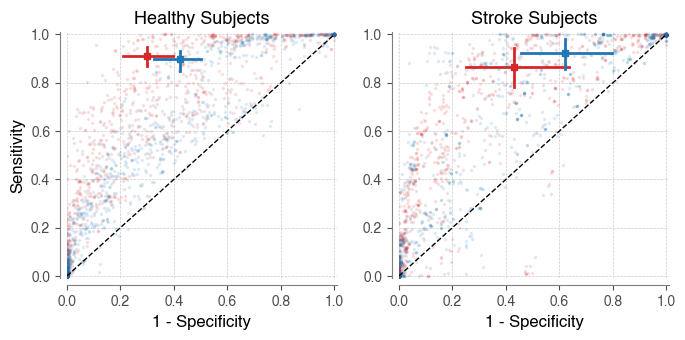

In [ ]:

# Figure.
fig = plt.figure(figsize=(7, 3.5))
ax = fig.add_subplot(121)
# Get Sens, and Spec.
# Number of bootstrap samples
means = {}
ci95 = {}

# Find the bootstrap means and CIs.
# Right Limb
_inxhr = ((losoperfdf["type"] == "healthy") &
          (losoperfdf["limb"] == "right"))
_xmean, _xci = compute_bootstrap_mean_ci(losoperfdf[_inxhr]["specificity"].values)
_ymean, _yci = compute_bootstrap_mean_ci(losoperfdf[_inxhr]["sensitivity"].values)
ax.plot(1 - _xci, [_ymean, _ymean], color="tab:red", alpha=1, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color="tab:red", alpha=1, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=4, color="tab:red", alpha=1)

# spec, sens vals
limb_inx = (gmac_perf["limb"] == "right")
N = np.sum(healthy_inx & limb_inx)
_randinx = np.random.choice(N, 1000, replace=False)
_spec = 1 - gmac_perf[healthy_inx & limb_inx]["specificity"].values
_sens = gmac_perf[healthy_inx & limb_inx]["sensitivity"].values
ax.plot(_spec[_randinx], _sens[_randinx], color="tab:red", marker=".", markersize=3,
        alpha=0.1, linestyle="None")

# Left Limb
_inxhr = ((losoperfdf["type"] == "healthy") &
          (losoperfdf["limb"] == "left"))
_xmean, _xci = compute_bootstrap_mean_ci(losoperfdf[_inxhr]["specificity"].values)
_ymean, _yci = compute_bootstrap_mean_ci(losoperfdf[_inxhr]["sensitivity"].values)
ax.plot(1 - _xci, [_ymean, _ymean], color="tab:blue", alpha=1, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color="tab:blue", alpha=1, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=4, color="tab:blue", alpha=1)

# spec, sens vals
limb_inx = (gmac_perf["limb"] == "left")
N = np.sum(healthy_inx & limb_inx)
_randinx = np.random.choice(N, 1000, replace=False)
_spec = 1 - gmac_perf[healthy_inx & limb_inx]["specificity"].values
_sens = gmac_perf[healthy_inx & limb_inx]["sensitivity"].values
ax.plot(_spec[_randinx], _sens[_randinx], color="tab:blue", marker=".", markersize=3,
        alpha=0.1, linestyle="None")
# ax.plot([1 - _xmean], [_ymean], marker="s", ms=4, color="tab:blue", alpha=1)

ax.plot([0, 1], [0, 1], lw=1, color="black", ls="--")
ax.set_ylim(-0.01, 1.01)
ax.set_xlim(0.0, 1.01)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.8', linestyle='--', linewidth=0.5);
ax.set_ylabel("Sensitivity", fontsize=12)
ax.set_xlabel("1 - Specificity", fontsize=12)
ax.set_title("Healthy Subjects", fontsize=13)

ax = fig.add_subplot(122)
# Unaffected Limb
_inxhr = ((losoperfdf["type"] == "stroke") &
          (losoperfdf["limb"] == "unaff"))
_xmean, _xci = compute_bootstrap_mean_ci(losoperfdf[_inxhr]["specificity"].values)
_ymean, _yci = compute_bootstrap_mean_ci(losoperfdf[_inxhr]["sensitivity"].values)
ax.plot(1 - _xci, [_ymean, _ymean], color="tab:red", alpha=1, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color="tab:red", alpha=1, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=4, color="tab:red", alpha=1)

# spec, sens vals
limb_inx = (gmac_perf["limb"] == "unaff")
N = np.sum(stroke_inx & limb_inx)
_randinx = np.random.choice(N, 1000, replace=False)
_spec = 1 - gmac_perf[stroke_inx & limb_inx]["specificity"].values
_sens = gmac_perf[stroke_inx & limb_inx]["sensitivity"].values
ax.plot(_spec[_randinx], _sens[_randinx], color="tab:red", marker=".", markersize=3,
        alpha=0.1, linestyle="None")

# Left Limb
_inxhr = ((losoperfdf["type"] == "stroke") &
          (losoperfdf["limb"] == "aff"))
_xmean, _xci = compute_bootstrap_mean_ci(losoperfdf[_inxhr]["specificity"].values)
_ymean, _yci = compute_bootstrap_mean_ci(losoperfdf[_inxhr]["sensitivity"].values)
ax.plot(1 - _xci, [_ymean, _ymean], color="tab:blue", alpha=1, lw=2)
ax.plot([1 - _xmean, 1 - _xmean], _yci, color="tab:blue", alpha=1, lw=2)
ax.plot([1 - _xmean], [_ymean], marker="s", ms=4, color="tab:blue", alpha=1)

# spec, sens vals
limb_inx = (gmac_perf["limb"] == "aff")
N = np.sum(stroke_inx & limb_inx)
_randinx = np.random.choice(N, 1000, replace=False)
_spec = 1 - gmac_perf[stroke_inx & limb_inx]["specificity"].values
_sens = gmac_perf[stroke_inx & limb_inx]["sensitivity"].values
ax.plot(_spec[_randinx], _sens[_randinx], color="tab:blue", marker=".", markersize=3,
        alpha=0.1, linestyle="None")
# ax.plot([1 - _xmean], [_ymean], marker="s", ms=4, color="tab:blue", alpha=1)

ax.plot([0, 1], [0, 1], lw=1, color="black", ls="--")
ax.set_ylim(-0.01, 1.01)
ax.set_xlim(0.0, 1.01)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.grid(color='0.8', linestyle='--', linewidth=0.5);
# ax.set_ylabel("Sensitivity", fontsize=12)
ax.set_xlabel("1 - Specificity", fontsize=12)
ax.set_title("Stroke Subjects", fontsize=13)

plt.tight_layout()

fig.savefig(pathlib.Path(basedir, "ROC_loso.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(basedir, "ROC_loso.svg"), bbox_inches="tight")

### LME model of performance

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

In [ ]:
summ_perf = pd.DataFrame(columns=["subjid", "limb", "method",
                                  "youden", "sensitivity", "specificity"])

# GMAC
for i, _subj in enumerate(subjs):
    # LOSO perf
    _subjinx = gmac_perf.subjtype == _subj
    _subjid = gmac_perf[_subjinx]["subject"].unique()[0]
    _limbs = gmac_perf[_subjinx]["limb"].unique()
    _arginx = ((gmac_perf.np == bestargs[i][0]) &
                (gmac_perf.fc == bestargs[i][1]) &
                (gmac_perf.nc == bestargs[i][2]) &
                (gmac_perf.nam == bestargs[i][3]) &
                (gmac_perf.p_th == bestargs[i][4]) &
                (gmac_perf.p_th_band == bestargs[i][5]) &
                (gmac_perf.am_th == bestargs[i][6]) &
                (gmac_perf.am_th_band == bestargs[i][7]))
    # Build perf DF
    _baseperdfrow = {"subjid": [_subj],
                        "method": ["GMAC"]}
    for _l in _limbs:
        _limbinx = gmac_perf.limb == _l
        _tempdf = gmac_perf[_subjinx & _limbinx & _arginx]
        summ_perf = pd.concat(
            [summ_perf,
                pd.DataFrame.from_dict(
                _baseperdfrow |
                {"limb": [_l],
                "youden": _tempdf["youden"].values,
                "sensitivity": _tempdf["sensitivity"].values,
                "specificity": _tempdf["specificity"].values})],
            ignore_index=True
        )

# Old GMAC, RF inter, RF intra
for i, _subj in enumerate(subjs):
    # LOSO perf
    _subjinx = gmac_perf.subjtype == _subj
    _subjid = gmac_perf[_subjinx]["subject"].unique()[0]
    _limbs = gmac_perf[_subjinx]["limb"].unique()
    # Build perf DF
    # Subash perf
    # Old GMAC
    _baseperdfrow = {"subjid": [_subj],
                     "method": ["Old GMAC"]}
    for _l in _limbs:
        _minx = subash22df[_l].method == "GMAC"
        _sinx = (subash22df[_l]["subject"] == _subjid)
        _tempdf = subash22df[_l][_minx & _sinx]
        summ_perf = pd.concat(
            [summ_perf,
                pd.DataFrame.from_dict(
                _baseperdfrow |
                {"limb": [_l],
                "youden": _tempdf["youden"].values,
                "sensitivity": _tempdf["sensitivity"].values,
                "specificity": _tempdf["specificity"].values})],
            ignore_index=True
        )
    # RF inter
    _baseperdfrow = {"subjid": [_subj],
                     "method": ["RF inter"]}
    for _l in _limbs:
        _minx = subash22df[_l].method == "RF inter"
        _sinx = (subash22df[_l]["subject"] == _subjid)
        _tempdf = subash22df[_l][_minx & _sinx]
        summ_perf = pd.concat(
            [summ_perf,
                pd.DataFrame.from_dict(
                _baseperdfrow |
                {"limb": [_l],
                "youden": _tempdf["youden"].values,
                "sensitivity": _tempdf["sensitivity"].values,
                "specificity": _tempdf["specificity"].values})],
            ignore_index=True
        )
    # RF intra
    _baseperdfrow = {"subjid": [_subj],
                     "method": ["RF intra"]}
    for _l in _limbs:
        _minx = subash22df[_l].method == "RF intra"
        _sinx = (subash22df[_l]["subject"] == _subjid)
        _tempdf = subash22df[_l][_minx & _sinx]
        summ_perf = pd.concat(
            [summ_perf,
                pd.DataFrame.from_dict(
                _baseperdfrow |
                {"limb": [_l],
                "youden": np.nanmean(_tempdf["youden"].values),
                "sensitivity": np.nanmean(_tempdf["sensitivity"].values),
                "specificity": np.nanmean(_tempdf["specificity"].values)})],
            ignore_index=True
        )

### Pairwise comparison

In [ ]:
method_groups = summ_perf.groupby(["method"])

# Genenrate new dataframes with new indices
_newdfs = {
    _name[0]: _group.set_index(["subjid", "limb"])
    for _name, _group in method_groups
}

# Rename columns by keyname
for _name, _df in _newdfs.items():
    _newdfs[_name] = _df.rename(columns={
        "youden": f"youden_{_name}",
        "sensitivity": f"sensitivity_{_name}",
        "specificity": f"specificity_{_name}"
    })
    # Remove method column
    _newdfs[_name] = _newdfs[_name].drop(columns=["method"])

# New DF list
_newdflist = [_df for _k, _df in _newdfs.items()]

# Join dataframes by the index
combdf = _newdflist[0].join(_newdflist[1:])

In [ ]:
outcome = "youden"
# GMAC vs. Old GMAC
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(combdf[f"{outcome}_GMAC"], combdf[f"{outcome}_Old GMAC"])

# Apply a multiple comparisons correction method (e.g., Bonferroni)
alpha = 0.05 / 3
print(f"[Old GMAC], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = combdf[f"{outcome}_GMAC"] - combdf[f"{outcome}_Old GMAC"]
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

# GMAC vs. Rf inter
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(combdf[f"{outcome}_GMAC"], combdf[f"{outcome}_RF inter"])

# Apply a multiple comparisons correction method (e.g., Bonferroni)
print(f"\n[RF inter], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = combdf[f"{outcome}_GMAC"] - combdf[f"{outcome}_RF inter"]
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

# GMAC vs. Rf intra
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(combdf[f"{outcome}_GMAC"], combdf[f"{outcome}_RF intra"])

# Apply a multiple comparisons correction method (e.g., Bonferroni)
print(f"\n[RF intra], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = combdf[f"{outcome}_GMAC"] - combdf[f"{outcome}_RF intra"]
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

[Old GMAC], youden
0.000
0.152 $\pm$ 0.172

[RF inter], youden
Not significant
0.010 $\pm$ 0.112

[RF intra], youden
0.000
-0.232 $\pm$ 0.189


In [ ]:
outcome = "sensitivity"
# GMAC vs. Old GMAC
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(combdf[f"{outcome}_GMAC"], combdf[f"{outcome}_Old GMAC"])

# Apply a multiple comparisons correction method (e.g., Bonferroni)
alpha = 0.05 / 3
print(f"[Old GMAC], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = combdf[f"{outcome}_GMAC"] - combdf[f"{outcome}_Old GMAC"]
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

# GMAC vs. Rf inter
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(combdf[f"{outcome}_GMAC"], combdf[f"{outcome}_RF inter"])

# Apply a multiple comparisons correction method (e.g., Bonferroni)
print(f"\n[RF inter], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = combdf[f"{outcome}_GMAC"] - combdf[f"{outcome}_RF inter"]
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

# GMAC vs. Rf intra
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(combdf[f"{outcome}_GMAC"], combdf[f"{outcome}_RF intra"])

# Apply a multiple comparisons correction method (e.g., Bonferroni)
print(f"\n[RF intra], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = combdf[f"{outcome}_GMAC"] - combdf[f"{outcome}_RF intra"]
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

[Old GMAC], sensitivity
0.000
0.141 $\pm$ 0.137

[RF inter], sensitivity
Not significant
0.027 $\pm$ 0.126

[RF intra], sensitivity
Not significant
-0.017 $\pm$ 0.177


In [ ]:
outcome = "specificity"
# GMAC vs. Old GMAC
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(combdf[f"{outcome}_GMAC"], combdf[f"{outcome}_Old GMAC"])

# Apply a multiple comparisons correction method (e.g., Bonferroni)
alpha = 0.05 / 3
print(f"[Old GMAC], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = combdf[f"{outcome}_GMAC"] - combdf[f"{outcome}_Old GMAC"]
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

# GMAC vs. Rf inter
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(combdf[f"{outcome}_GMAC"], combdf[f"{outcome}_RF inter"])

# Apply a multiple comparisons correction method (e.g., Bonferroni)
print(f"\n[RF inter], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = combdf[f"{outcome}_GMAC"] - combdf[f"{outcome}_RF inter"]
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

# GMAC vs. Rf intra
# Statistical comparison: Perform paired t-tests
t_stat, p_val = stats.ttest_rel(combdf[f"{outcome}_GMAC"], combdf[f"{outcome}_RF intra"])

# Apply a multiple comparisons correction method (e.g., Bonferroni)
print(f"\n[RF intra], {outcome}")
if p_val < alpha:
    print(f"{p_val:0.3f}")
else:
    print("Not significant")

_diff = combdf[f"{outcome}_GMAC"] - combdf[f"{outcome}_RF intra"]
print(f"{np.mean(_diff):0.3f} $\\pm$ {np.std(_diff):0.3f}")

[Old GMAC], specificity
Not significant
0.010 $\pm$ 0.190

[RF inter], specificity
Not significant
-0.016 $\pm$ 0.159

[RF intra], specificity
0.000
-0.214 $\pm$ 0.206
